## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [487]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed

# viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns

# feems
import sys
sys.path.append('../../')
from feems import SpatialGraph, Viz, Objective
from feems.joint_ver import Joint_SpatialGraph, Joint_Objective, loss_wrapper
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes, simulate_genotypes_w_admixture
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import * 

# popgen
# import msprime
# import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "Helvetica"
# })
plt.rcParams['axes.axisbelow'] = True
plt.style.use('bmh')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a function to calculate Wishart likelihood from a matrix of pairwise resistance distances 

Easier to model $R$ as as function of admixture proportion, $c$ instead of modeling $L^\dagger$ as a function of $c$ 

In [777]:
def get_FEEMS_demes_ll_w_c(sp_graph, obj, wt, q, lrn, c, df=100, sigstar=1):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    resmat = Rmat - 2*np.diag(1/sp_graph.q)
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, df, -sigstar/df*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2
    # return sp.stats.wishart.logpdf(-C @ resmat @ C.T, df, 2*C @ sp_graph.S @ C.T) 

def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='matrix'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)       

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.eye(sp_graph.n_observed_nodes); BR2 = np.zeros_like(BR1)

        ## sd
        BR1[lrn[0][0],lrn[0][0]] = 0.5*c**2-1.5*c+1
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            # id
            BR1[i,i] = 1-c
            # sd
            BR1[i,lrn[0][0]] = 0.5*(c**2-c)
            BR1[lrn[0][0],i] = BR1[i,lrn[0][0]]
            # is
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]

        BQ1 = np.eye(sp_graph.n_observed_nodes); BQ2 = np.eye(sp_graph.n_observed_nodes); BQ3 = np.zeros_like(BQ1)

        BQ1[lrn[0][0],lrn[0][0]] = 1+c
        BQ2[lrn[0][1],lrn[0][1]] = 1-c 
        ## this introduces an extra c component in the off-diagonal of BQ1 which is ok for c=0, but not otherwise
        # id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            BQ3[i,lrn[0][1]] = c
            BQ3[lrn[0][1],i] = BQ3[i,lrn[0][1]]
            BQ1[i,lrn[0][0]] = c
            BQ1[lrn[0][0],i] = BQ1[i,lrn[0][0]]
            # BQ2[i,i] = 1-c

        Rismat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

        resmat = BR1@Rmat + np.multiply(BR2,Rismat) + BQ1@Q1mat + Q1mat.T@BQ2 - 2*np.diag(1/sp_graph.q) + np.multiply(BQ3,Qismat)

    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

In [779]:
get_FEEMS_demes_nll_w_c(0.4, sp_graph, obj, [(23,56)], form='matrix')

LinAlgError: 23-th leading minor of the array is not positive definite

In [200]:
def get_FEEMS_demes_ll_w_c_x(sp_graph, obj, lrn, c, x):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    resmat = Rmat - 2*np.diag(1/sp_graph.q)
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (4*c*x-c**2*x+1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + (4*c*x-c**2*x+c)/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2

In [448]:
## writing code to pass in gradient wrt c (using scipy.optimize.minimize)
## this is basic code to check if the analytical derivative was found correctly and if I can code it in correctly 
def get_grad_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    resmat = Rmat - 2*np.diag(1/sp_graph.q)
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    Rder = np.zeros_like(Rmat)
    ## sd
    Rder[lrn[0][0],lrn[0][1]] = (c-1.5)*Rder[lrn[0][0],lrn[0][1]]
    Rder[lrn[0][1],lrn[0][0]] = Rder[lrn[0][0],lrn[0][1]] 

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        Rder[i,lrn[0][1]] = -Rmat[i,lrn[0][1]] + Rmat[i,lrn[0][0]] + (c-0.5)*Rmat[lrn[0][0],lrn[0][1]] 
        Rder[lrn[0][1],i] = Rder[i,lrn[0][1]]

    obj.grad_obj_q = np.zeros(len(sp_graph))
    obj.grad_obj_q[:sp_graph.n_observed_nodes] = sp_graph.n_snps * (np.diag(obj.comp_A - obj.comp_B) @ sp_graph.q_inv_grad) 

    qder = np.zeros_like(Rder)
    qder[lrn[0][0],lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]-1/sp_graph.q[lrn[0][1]]
    qder[lrn[0][1],lrn[0][0]] = qder[lrn[0][0],lrn[0][1]]
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        qder[i,lrn[0][1]] = -1/sp_graph.q[lrn[0][1]] + 1/sp_graph.q[lrn[0][0]]
        qder[lrn[0][1],i] = qder[i,lrn[0][1]]

    # qder = 0.25*sp_graph.n_snps*(np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T @ np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).reshape((1,-1)) @ qder.reshape((-1,1))
    qder = 0.25*sp_graph.n_snps*(np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) @ np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T).reshape((1,-1)) @ qder.reshape((-1,1))

    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T), -(obj.grad_obj_L.reshape((1,-1)) @ Rder.reshape((-1,1)))[0] #np.ravel(np.dot(obj.grad_obj_L.reshape((1,-1),order='F'),Rder))[0]

In [452]:
# Rmat.reshape((-1,1),order='F')
# obj.grad_obj_L, obj.grad_obj_L.reshape((1,-1),order='F')
# c = 0.6885
## plot the derivative as a function of c (it should approach 0 as c -> 0.688)
# derc = []
# for c in np.linspace(0,1,25):
#     derc.append(get_grad_FEEMS_demes_nll_w_c(c, sp_graph, obj, [(8,27)],)[1])
# plt.plot(np.linspace(0,1,25),np.array(derc),'ko'); plt.xlabel(r'$c$'); plt.ylabel(r'$\frac{\partial \ell (c)}{\partial c}$'); plt.axvline(0.6,color='red')

# obj.grad_obj_q = np.zeros(len(sp_graph))
# obj.grad_obj_q[:sp_graph.n_observed_nodes] = sp_graph.n_snps * (np.diag(obj.comp_A - obj.comp_B) @ sp_graph.q_inv_grad)
# obj.grad_obj_q

# 0.25*sp_graph.n_snps*(np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T @ np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).reshape((1,-1)) @ qder.reshape((-1,1))
# np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) @ (obj.comp_A-obj.comp_B) @ np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T

# plt.imshow(qder); plt.colorbar()

# 0.25*sp_graph.n_snps*(np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) @ (obj.comp_A - obj.comp_B) @ np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T).reshape((1,-1)) @ qder.reshape((-1,1))

# sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,[0.1],args=(sp_graph,obj,lrn),method='L-BFGS-B',bounds=[(0,1)],jac=True)

array([-207.17903512])

Object `scipy.optimize.minimize` not found.


In [300]:
## Look at how JtDobsJ is calculated in EEMS source code
# np.matmul(sp_graph.n_samples_per_obs_node_permuted.reshape(1,-1),sp_graph.n_samples_per_obs_node_permuted.reshape(-1,1))
# Pairs = sp_graph.n_samples_per_obs_node_permuted.reshape(-1,1,) @ sp_graph.n_samples_per_obs_node_permuted.reshape(1,-1) - np.diag(sp_graph.n_samples_per_obs_node_permuted)
# diffs = np.loadtxt("/Users/vivaswat/feems/feems/data/sims/infiles/simgrd.diffs")
# Dstar = J.T@diffs@J/Pairs
# plt.plot(np.ravel(Dstar),np.ravel(squareform(pdist(sp_graph.frequencies,"sqeuclidean")))/sp_graph.n_snps,'ko',alpha=0.4)
# JtDobsJ = np.loadtxt("/Users/vivaswat/feems/feems/data/sims/outfiles/simgrd/chain22/rdistJtDobsJ.txt")
# plt.imshow(-C@JtDobsJ@C.T); plt.colorbar(); 
# plt.imshow(-C@Dstar@C.T); plt.colorbar()
# plt.plot(JtDobsJ[np.tril_indices(16)],Dstar[np.tril_indices(16)],'ko',alpha=0.4); plt.axline((0.3,0.3),slope=1,color='grey')
# np.diag(JtDobsJ), np.diag(Dstar)

LinregressResult(slope=0.0008447734823054908, intercept=-0.09110141029188856, rvalue=0.9801114865818458, pvalue=0.0, stderr=2.1654755464160985e-06, intercept_stderr=0.0018212738710352593)


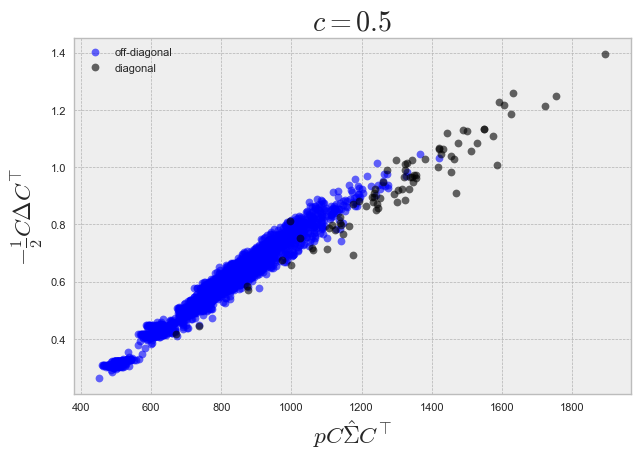

In [690]:
# J = np.zeros((np.sum(sp_graph.n_samples_per_obs_node_permuted),sp_graph.n_observed_nodes))
# cnt = 0
# for o in range(sp_graph.n_observed_nodes):
#     J[cnt:(cnt+sp_graph.n_samples_per_obs_node_permuted[o]+1),o] = 1
#     cnt += sp_graph.n_samples_per_obs_node_permuted[o]

C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

# Pairs = sp_graph.n_samples_per_obs_node_permuted.reshape(-1,1,) @ sp_graph.n_samples_per_obs_node_permuted.reshape(1,-1) - np.diag(sp_graph.n_samples_per_obs_node_permuted)
# Dstar = squareform(pdist(J.T@sp_graph.genotypes,"sqeuclidean"))/1500/Pairs#J.T@(squareform(pdist(gen_test_1e,"sqeuclidean"))/gen_test_1e.shape[1])@J/Pairs
# Dstar = squareform(pdist(sp_graph.frequencies*np.sqrt(sp_graph.mu*(1-sp_graph.mu)),"sqeuclidean"))/1500 ## this does not give us good results (needs to be 'scaled' by SNP factor)
Dstar = squareform(pdist(sp_graph.frequencies,"sqeuclidean"))/1500
# resmat = -2*obj.Linv- np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T - np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) #np.zeros_like(obj.Linv) 
# resmat = -2*obj.Linv-2*np.diag(1/sp_graph.q)
# resmat = resmat - np.diag(resmat)
# for i in range(obj.Linv.shape[0]):
#     for j in range(i,obj.Linv.shape[0]):
#         resmat[i,j] = -2*obj.Linv[i,j] + Linv[i,i] + Linv[j,j] #+ sp_graph.q[i] + sp_graph.q[j]
#         resmat[j,i] = resmat[i,j]
#         if i==j:
#             resmat[i,i] -= 2/sp_graph.q[i]
Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
# Qmat = np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))
Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))
resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
c = 0.5
resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]
for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
    resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
    resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
# plt.imshow(-C@Dstar@C.T); plt.colorbar(); plt.title(r'$-CDC^\top$'); plt.show()
# plt.imshow(-0.5*resmat,); plt.colorbar(); plt.title(r'$\Delta $')
# np.diag(C@resmat@C.T), sp_graph.q

print(sp.stats.linregress(np.ravel(sp_graph.n_snps*C@sp_graph.S@C.T),np.ravel(-0.5*C@resmat@C.T)))
plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],(-0.5*C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.xlabel(r'$pC\hat \Sigma C^\top$'); plt.ylabel(r'$-\frac{1}{2}C\Delta C^\top$'); 
plt.plot(np.diag(sp_graph.n_snps*C@sp_graph.S@C.T),np.diag(-0.5*C@resmat@C.T),'ko',label='diagonal',alpha=0.6); plt.title(r'$c={}$'.format(c,0.975)); plt.legend();
# plt.imshow(2*C@sp_graph.S@C.T,cmap='Greys',); plt.colorbar(); plt.title('observed covariance matrix'); plt.show()
# plt.imshow(-C@resmat@C.T,cmap='Greys'); plt.title(r'$c=1.$'); plt.colorbar()
plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[:,lrn[0][1]-1],(-0.5*C@resmat@C.T)[:,lrn[0][1]-1],'g+',label='id'); plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-0.5*C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); 

# print(sp.stats.linregress(np.ravel(C@Dstar@C.T),np.ravel(C@resmat@C.T)))
# plt.plot((-C@Dstar@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],(-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal'); plt.xlabel(r'$-C D C^\top$'); plt.ylabel(r'$-C\Delta C^\top$'); plt.axline((0,0),slope=1,color='grey'); 
# plt.plot(np.diag(-C@Dstar@C.T),np.diag(-C@resmat@C.T),'ko',label='diagonal'); plt.legend(); plt.show()

# np.diag(-C@Dstar@C.T), np.diag(-C@(resmat-np.diag(sp_graph.q))@C.T)
# plt.plot((-C@Dstar@C.T)[np.tril_indices(15,-1)],(-0.1*C@(resmat-np.diag(sp_graph.q))@C.T)[np.tril_indices(15,-1)],'bo',label='off-diagonal'); plt.xlabel(r'$-CDC^\top$'); plt.ylabel(r'$-\frac{\sigma^2}{\nu}C\Delta C^\top$'); plt.legend(); plt.axline((0,0),slope=1,color='grey')
# np.diag(sp_graph.S), sp_graph.q
# print(sp.stats.linregress(np.ravel(-0.5*C@Dstar@C.T),np.ravel(C@np.linalg.inv(obj.inv_cov)@C.T)))
# plt.plot((C@sp_graph.S@C.T)[np.tril_indices(79,-1)],(C@np.linalg.inv(obj.inv_cov)@C.T)[np.tril_indices(79,-1)],'bo',label='off-diagonal'); plt.plot(np.diag(C@sp_graph.S@C.T),np.diag(C@np.linalg.inv(obj.inv_cov)@C.T),'ko',label='diagonal'); plt.xlabel(r'$C\hat \Sigma C^\top$'); plt.ylabel(r'$C X_{cov} C^\top$'); plt.legend(); plt.axline((0,0),slope=1,color='grey'); plt.show()

0.9554915412939913


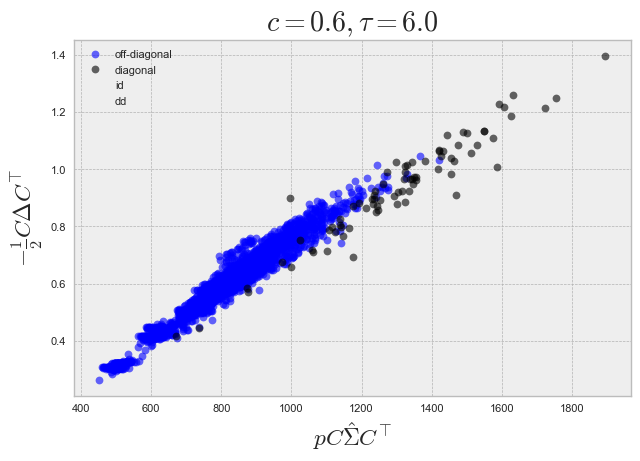

In [635]:
C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

Dstar = squareform(pdist(sp_graph.frequencies,"sqeuclidean"))/1500

Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T +  np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)

c = 0.2; x = 0/sp_graph.q[lrn[0][0]]

resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (4*c*x-c**2*x+1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]
for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
    resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + (4*c*x-c**2*x+c)/sp_graph.q[lrn[0][0]]
    resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

print(sp.stats.linregress(np.ravel(sp_graph.n_snps*C@sp_graph.S@C.T),np.ravel(-0.5*C@resmat@C.T))[2]**2)
plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],(-0.5*C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.xlabel(r'$pC\hat \Sigma C^\top$'); plt.ylabel(r'$-\frac{1}{2}C\Delta C^\top$'); 
plt.plot(np.diag(sp_graph.n_snps*C@sp_graph.S@C.T),np.diag(-0.5*C@resmat@C.T),'ko',label='diagonal',alpha=0.6); plt.title(r'$c={},\tau={}$'.format(0.6,np.ceil(1*sp_graph.q[lrn[0][0]])//2)); 
plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[:,55],(-0.5*C@resmat@C.T)[:,55],'g+',label='id'); plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[55,55],(-0.5*C@resmat@C.T)[55,55],'rx',label='dd'); plt.legend();

In [751]:
## need to construct a coefficient matrix that is when multiplied with Rmat gives me the right elements 
def get_coeff_mat(lrn,c,o):
    coeffmat = np.eye(o); coeffmat1 = np.zeros_like(coeffmat)

    ## sd
    coeffmat[lrn[0][0],lrn[0][0]] = 0.5*c**2-1.5*c+1
    ## id
    for i in set(range(coeffmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        # id
        coeffmat[i,i] = 1-c
        # sd
        coeffmat[i,lrn[0][0]] = 0.5*(c**2-c)
        coeffmat[lrn[0][0],i] = coeffmat[i,lrn[0][0]]
        # is
        coeffmat1[i,lrn[0][1]] = c
        coeffmat1[lrn[0][1],i] = coeffmat1[i,lrn[0][1]]

    Qcoeffmat = np.eye(o); Q1coeffmat = np.eye(o); Q2coeffmat = np.zeros_like(Qcoeffmat)

    Qcoeffmat[lrn[0][0],lrn[0][0]] = 1+c
    Q1coeffmat[lrn[0][1],lrn[0][1]] = 1-c 
    # is
    for i in set(range(coeffmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        Q2coeffmat[i,lrn[0][1]] = c
        Q2coeffmat[lrn[0][1],i] = Q2coeffmat[i,lrn[0][1]]

    return coeffmat, coeffmat1, Qcoeffmat, Q1coeffmat, Q2coeffmat

Bcmat, B1cmat, Qcmat, Q1cmat, Q2cmat = get_coeff_mat(lrn,0.,sp_graph.n_observed_nodes)
Rismat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat)
for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
    Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
    Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

    Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
    Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

Text(0.5, 0, 'EEMS $\\hat D$')

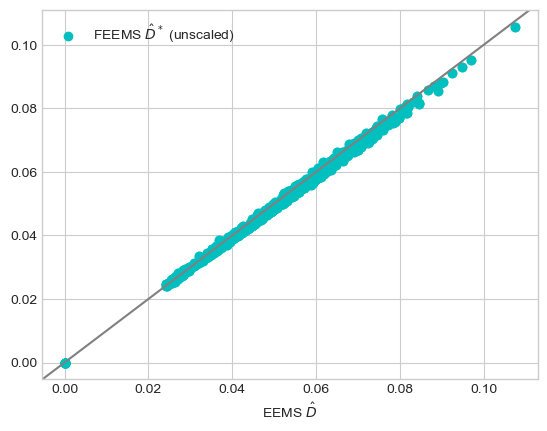

In [133]:
## how to match Dstar with -Sigma
Dgen = squareform(pdist(J.T@sp_graph.genotypes,"sqeuclidean"))/1500/Pairs
Dfreqscaled = squareform(pdist(sp_graph.frequencies,"sqeuclidean"))/1500; Sscaled = deepcopy(sp_graph.S)
# sp_graph = Joint_SpatialGraph(gen_test_1e, coord_def, grid_def, edge_def,scale_snps=False)
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
# Dfreqscaled = squareform(pdist(sp_graph.frequencies,"sqeuclidean"))/1200
unscaledfreq = sp_graph.frequencies * np.sqrt(sp_graph.mu * (1 - sp_graph.mu))
Dfrequnscaled = squareform(pdist(unscaledfreq,"sqeuclidean"))/1500
plt.scatter(Dgen,Dfreqscaled,color='g',label=r'FEEMS $\hat D^*$ (scaled)'); plt.axline((0,0),slope=12,color='grey',ls='--') #plt.scatter(Dgen,-0.1*Sscaled,color='b',label='Sscaled')
plt.scatter(Dgen,Dfrequnscaled,color='c',label=r'FEEMS $\hat D^*$ (unscaled)'); plt.legend(); plt.axline((0,0),slope=1,color='grey'); plt.xlabel(r'EEMS $\hat D$')

In [168]:
randedge = [tuple(np.random.choice(range(80),size=2,replace=False)) for _ in range(30)]
randedge = list(set(randedge)-set(sp_graph.edges)); 
truew = np.append(np.zeros(len(randedge)),[0.6,0,0,0,0,0,])
for e in [(23,56),(22,56),(24,56),(23,57),(23,55),(24,55)]:
    randedge.append(e)
# for e in [(56,23),(56,22),(56,24),(57,23),(55,23),(55,24)]:
#     randedge.append(e)
# for e in [(8,27),(7,27),(9,27),(8,26),(8,28)]:
#     randedge.append(e)
# for e in [(23,92),(22,92),(91,23),(92,24),(101,36),(102,36),(35,101),(117,36),(35,118)]:
#     randedge.append(e)
# print(randedge)

isc = np.zeros(len(randedge)); logc = np.zeros(len(randedge))
for ie, e in enumerate(randedge):
    llc = []
    for c in np.linspace(0,1,25): 
        llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [e], c, df=1500, sigstar=0.5)[1])
    # logc[ie] = np.linspace(0,1,12)[np.argmin(np.abs(llc-np.max(llc)+2))] # llc[0] - llc[-1]
    # if np.argmax(llc)!=0:
    #     isc[ie] = 1
    isc[ie] = np.linspace(0,1,25)[np.argmax(llc)]

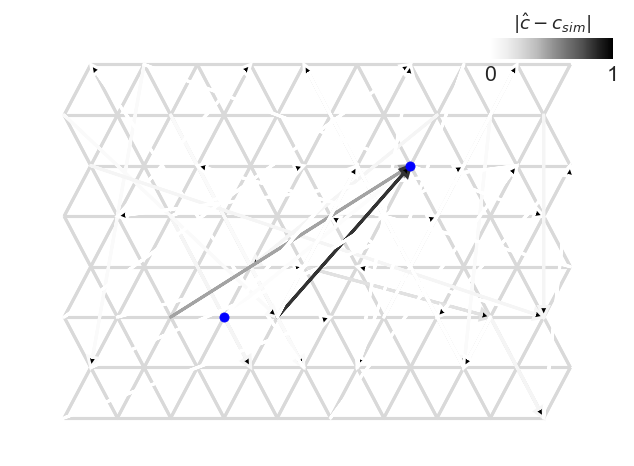

In [169]:
# plt.style.use('fivethirtyeight')
# plt.plot(grid_def[:,0],grid_def[:,1],'o',color='grey',alpha=0.8); plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid()
# plt.plot(grid_def[lrn[1][0],0],grid_def[lrn[1][0],1],'bo'); plt.plot(grid_def[lrn[1][1],0],grid_def[lrn[1][1],1],'bo'); plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid()
# for ie, e in enumerate(randedge):
# for ie in range(-6,0):
#     plt.plot((grid_def[randedge[ie][0],0],grid_def[randedge[ie][1],0]),(grid_def[randedge[ie][0],1],grid_def[randedge[ie][1],1]),color='{}'.format(1-np.abs(isc[ie]-truew[ie])),markersize=1)
# plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=mpl.cm.Greys), orientation='vertical', label=r'$ |\hat c - c_{sim}|$')
# plt.plot(grid_def[lrn[0][0],0],grid_def[lrn[0][0],1],'bo',markersize=8); plt.plot(grid_def[lrn[0][1],0],grid_def[lrn[0][1],1],'bo',markersize=8);
# plt.style.use('seaborn-whitegrid')

fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False)
for ie in range(len(randedge)):
    v.draw_arrow([randedge[ie]],np.abs(isc[ie]-truew[ie]))
ax.scatter(v.grid[lrn[0][0],0],v.grid[lrn[0][0],1],marker='o',color='b'); ax.scatter(v.grid[lrn[0][1],0],v.grid[lrn[0][1],1],marker='o',color='b');
v.draw_c_colorbar()

In [771]:
# (grid_def[randedge[-1][0],0],grid_def[randedge[ie][1],0]),(grid_def[randedge[ie][0],1],grid_def[randedge[ie][1],1])

In [775]:
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
llc = []
for c in np.linspace(0,1,20): 
    # llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [(23,56)], c, df=1500, sigstar=0.5)[0])
    llc.append(-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [(23,56)], form='matrix'))
plt.plot(np.linspace(0,1,20),llc,'ko'); plt.xlabel(r'c'); plt.ylabel(r'log-lik'); plt.axvline(0.6,color='red'); 
plt.axvline(np.linspace(0,1,20)[np.argmax(llc)],color='grey',ls='--')

LinAlgError: 23-th leading minor of the array is not positive definite

In [448]:
llx = []
for x in np.linspace(0,1,20): 
    llx.append(get_FEEMS_demes_ll_w_c_x(sp_graph, obj, [(8,27)], 0.6, x,)[0])
plt.plot(np.linspace(0,1,20),llx,'ko'); plt.xlabel(r'$x$'); plt.ylabel(r'log-lik'); plt.axvline(4/sp_graph.q[8],color='red'); 
plt.axvline(np.linspace(0,1,20)[np.argmax(llx)],color='grey',ls='--')

# cnum = 20; xnum = 20; llcx = np.zeros((cnum,xnum)); R2cx = np.zeros_like(llcx)
# for ic, c in enumerate(np.linspace(0,1,cnum)):
#     for ix, x in enumerate(np.linspace(0,1,xnum)):
#         llcx[ic,ix], R2cx[ic,ix] = get_FEEMS_demes_ll_w_c_x(sp_graph, obj, [(8,27)], c, x)

NameError: name 'get_FEEMS_demes_ll_w_c_x' is not defined

In [5]:
# gen_test_1e = deepcopy(gen_test_225)
sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

# plt.hist(sp_graph.w,20); plt.axvline(np.exp(0.5),color='k')
# Fst = comp_fst_mat(gen_test_81,30,81)
# plt.imshow(Fst,cmap='Blues'); plt.grid(); plt.colorbar()

constant-w/variance fit, converged in 128 iterations, train_loss=-46932.4721821
lambda=3.0000000, alpha=0.5568396, converged in 18 iterations, train_loss=-48085.5971903


In [468]:
# llc = []
# [llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [(8,27)], c, df=2000, sigstar=0.15)) for c in np.linspace(0,1,21)]
# sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
# llc = []
# [llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [(8,27)], c, df=2000, sigstar=0.15)) for c in np.linspace(0,1,21)] 

In [4]:
## starting fresh with a simple 6x6 grid to see if the computed log-lik from FEEMS is correlated with my function
n_rows, n_columns = 8, 10
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)

lrn = [(23,56)] # lrn=[(23,92),(101,36)]
gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[0.6], time_of_adm=[0.000001])
# gen_test_128_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[0.6], time_of_adm=[3])
# gen_test_128 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)
# sp_graph = Joint_SpatialGraph(gen_test_1e, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

# estcR2mat = np.zeros((16,5)); 
# estcllmat = np.zeros((16,5))
# for ic, truec in enumerate([0,0.25,0.5,0.75,1]):
#     for n in range(16):
#         # gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[truec], time_of_adm=[0.000001])
#         # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),gen_test_36_adm,delimiter=',',fmt='%f')
#         gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),delimiter=',')
#         sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
#         obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
#         llc = []
#         [llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [(8,27)], c, df=1500, sigstar=0.5)) for c in np.linspace(0,1,21)]       
        
#         estcllmat[n,ic] = np.linspace(0,1,21)[np.argmax(np.array(llc)[:,0])]
#         # estcR2mat[n,ic] = np.linspace(0,1,21)[np.argmax(np.array(llc)[:,1])]
        
# nllcomp = np.zeros((8,2))
# for n in range(8):
#     gen_test_1e = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/gentest{}.csv".format(n+2),delimiter=',') ##simulate_genotypes(graph_def, target_n_snps=1500, n_print=600, mu=1)
# #     ##np.savetxt('/Users/vivaswat/feems/feems/data/sims/infiles/simgrd{}.diffs'.format(n+11),squareform(pdist(gen_test_1e,"sqeuclidean"))/gen_test_1e.shape[1],fmt='%f')

#     sp_graph = Joint_SpatialGraph(gen_test_1e, coord_def, grid_def, edge_def)
#     sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
#     nllcomp[n,0] = obj.neg_log_lik() 

#     nllcomp[n,1] = -get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [(5,10)], 0, df=1500, sigstar=0.5)[0]

#     # trA = sp_graph.S @ (obj.Linv + np.diag(sp_graph.q))
#     # nllcomp[n,1] = get_FEEMS_nll(sp_graph, obj,) #sp_graph.n_snps*(np.trace(trA) - (obj.Linv + np.diag(sp_graph.q)).sum(axis=0) @ trA.sum(axis=1) / trA.sum() - np.log(np.linalg.det(obj.Linv + np.diag(sp_graph.q))*sp_graph.n_observed_nodes/trA.sum())) #-sp.stats.wishart.logpdf(sp_graph.n_snps*sp_graph.S,sp_graph.n_snps,np.linalg.inv(obj.inv_cov))
#     # pilogl = np.loadtxt("/Users/vivaswat/feems/feems/data/sims/outfiles/simgrd/chain{}/mcmcpilogl.txt".format(n+11))
#     # df2 = np.loadtxt("/Users/vivaswat/feems/feems/data/sims/outfiles/simgrd/chain{}/mcmcthetas.txt".format(n+11))
#     # sigstar, df = df2.mean(axis=0)
#     # nllcomp[n,1] = pilogl.mean(axis=0)
#     # trA = sp_graph.S @ obj.inv_cov
#     # trB = obj.inv_cov.sum(axis=0) @ trA.sum(axis=1)
#     nllcomp[n,2] = -sp.stats.wishart.logpdf(C@sp_graph.S@C.T,50,C@np.linalg.inv(obj.inv_cov)@C.T)#get_FEEMS_as_EEMS_nll(sp_graph, obj, sp_graph.w, sp_graph.q,)#sp_graph.n_snps*(np.trace(sp_graph.S@obj.inv_cov) - obj.trB / obj.denom - np.log(np.linalg.det(obj.inv_cov)*sp_graph.n_observed_nodes/obj.denom))#get_FEEMS_as_EEMS_nll(sp_graph, obj.Linv, sp_graph.w, sp_graph.q,)
#     print(nllcomp[n,])

Simulating ~SNP 0
Simulating ~SNP 1000


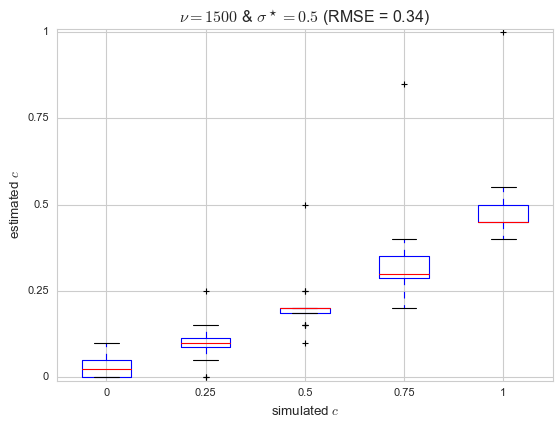

In [367]:
# plt.boxplot(estcR2mat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'$R^2$ (RMSE = {})'.format(np.round(np.sqrt(np.mean((estcR2mat-np.array([0,0.25,0.5,0.75,1]))**2)),2))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); #plt.axline((1,0),slope=0.25,color='grey'); 
plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'$\nu=1500$ & $\sigma^\star = 0.5$ (RMSE = {})'.format(np.round(np.sqrt(np.mean((estcllmat-np.array([0,0.25,0.5,0.75,1]))**2)),2))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); #plt.axline((1,0),slope=0.25,color='grey'); 
# gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(25,10),delimiter=',')
# sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

In [396]:
# print(np.polyfit(nllcomp[:,1],nllcomp[:,2],deg=1))
# df = pd.DataFrame(nllcomp, columns=['FEEMS','EEMS-like'])
# pd.plotting.scatter_matrix(df,alpha=0.7,color='k',marker='o',diagonal='kde',figsize=(5,5),range_padding=0.075)
# plt.scatter(nllcomp[:,0],nllcomp[:,1],color='k'); plt.xlabel('log-lik from FEEMS model'); plt.ylabel('log-lik from EEMS-like model')
# edgew = np.zeros((len(edge_def),5));
# for ic, c in enumerate([0,0.25,0.5,0.75,1]):
#     gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(c*100),10),delimiter=',')
#     sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
#     obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
#     # edgew[:,ic] = sp_graph.w
#     fig = plt.figure(dpi=110)
#     ax = fig.add_subplot(1, 1, 1)
#     v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, #weights=w,
#             edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
#     v.draw_edges(use_weights=True)
#     v.draw_obs_nodes(use_ids=False)
# plt.plot(edgew[:,0],edgew[:,-1],'bo',label=r'$c=1$'); plt.plot(edgew[:,0],edgew[:,1],'ko',alpha=0.5,label=r'$c=0.25$'); plt.xlabel('edge weights (NO admixture)'); plt.ylabel('edge weights (with admixture)'); plt.legend()

In [113]:
## ad-hoc way of testing whether there is any signal in the data
## increase in log-lik over next best edge on manually misassigning inds from one deme to another
# plt.scatter(np.array([5,10,15,25,29])*10/3,[0.1,31,83,240,108],color='k',alpha=0.7); plt.xlabel('% of inds misassigned'); plt.semilogy()
# plt.plot(np.array([1,3])*10/3,[0,0],'kx',markersize=10); plt.ylabel('increase in log-lik over next best edge'); plt.grid(); 

# obj_lr_asym.Linv[8,8], obj_lr_asym.Linv[8,27], obj_lr_asym.Linv[27,27], obj_asym.Linv[8,8], obj_asym.Linv[8,27], obj_asym.Linv[27,27]

# plt.scatter(np.diag(obj_asym.Linv),np.diag(obj_lr_asym.Linv),color='k',alpha=0.8); plt.axline((0.1,0.1),slope=1,color='grey'); plt.xlabel(r'diag $L$'); plt.ylabel(r"diag $L'$"); plt.plot(obj_asym.Linv[27,27],obj_lr_asym.Linv[27,27],'*',markersize=10,label='Ldd'); plt.plot(obj_asym.Linv[8,8],obj_lr_asym.Linv[8,8],'r*',markersize=10,label='Lss'); plt.legend(); plt.show()
# np.polyfit(np.diag(obj_asym.Linv),np.diag(obj_lr_asym.Linv),deg=1)

# plt.scatter(np.ravel(np.triu(obj_asym.Linv,1)),np.ravel(np.triu(obj_lr_asym.Linv,1)),color='k',alpha=0.6); plt.axline((0,0),slope=1,ls='--',color='grey'); plt.plot(obj_asym.Linv[8,27],obj_lr_asym.Linv[8,27],'r*',markersize=10); plt.xlabel(r'$L$'); plt.ylabel(r"$L'$");
# np.polyfit(np.ravel(np.triu(obj_asym.Linv,1)),np.ravel(np.triu(obj_lr_asym.Linv,1)),deg=1)

In [553]:
## do a similar simulation to below but estimate the edge weight of the LRE (increasing admixture prop should give higher edge weights)
nsims = 10
estw = np.zeros((nsims,4))
for ic, c in enumerate([0,0.3,0.7,1]):
    for n in range(nsims):
        # gen_test_1e_asym = simulate_genotypes(graph_def, target_n_snps=1200, mu=1e-1, n_print=500, asymmetric=False, long_range_nodes=lrn, long_range_edges=[5])
        gen_test_1e_asym = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=500, n_e=1, mu=1, long_range_nodes=lrn, admixture_props=[c], time_of_adm=[0.0001])

        sp_Graph_asym = Joint_SpatialGraph(gen_test_1e_asym, coord_def, grid_def, edge_def)
        sp_Graph_asym.fit(lamb=3., optimize_q='n-dim'); 

        sp_graph_asym = Joint_SpatialGraph(gen_test_1e_asym, coord_def, grid_def, np.array(edges_lr), long_range_edges=lrn)
        sp_graph_asym.fit(lamb=3.,optimize_q='n-dim'); 

        estw[n,ic] = sp_graph_asym.w[sp_graph_asym.lre_idx]

    print(estw[:,ic])

Simulating ~SNP 0
Simulating ~SNP 500
Simulating ~SNP 1000
constant-w/variance fit, converged in 135 iterations, train_loss=-15731.3546068
lambda=3.0000000, alpha=0.5759423, converged in 6 iterations, train_loss=-16093.6383624
constant-w/variance fit, converged in 135 iterations, train_loss=-15671.0148642
lambda=3.0000000, alpha=0.5892372, converged in 6 iterations, train_loss=-16069.2478910
Simulating ~SNP 0
Simulating ~SNP 500
Simulating ~SNP 1000
constant-w/variance fit, converged in 136 iterations, train_loss=-15798.7745152
lambda=3.0000000, alpha=0.5232029, converged in 6 iterations, train_loss=-16041.7115950
constant-w/variance fit, converged in 143 iterations, train_loss=-15719.8939827
lambda=3.0000000, alpha=0.5349029, converged in 7 iterations, train_loss=-16020.4245182
Simulating ~SNP 0
Simulating ~SNP 500
Simulating ~SNP 1000
constant-w/variance fit, converged in 150 iterations, train_loss=-16743.9880195
lambda=3.0000000, alpha=0.5221732, converged in 6 iterations, train_los

In [607]:
nsims = 10
estc = np.zeros((nsims,3))
estcsimp = np.zeros((nsims,3))
for ic, c in enumerate([0.15,0.5,0.85]):
    for n in range(nsims):
        # gen_test_1e_asym = simulate_genotypes(graph_def, target_n_snps=1200, mu=1e-1, n_print=500, asymmetric=False, long_range_nodes=lrn, long_range_edges=[5])
        gen_test_1e_asym = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=500, n_e=1, mu=1, long_range_nodes=lrn, admixture_props=[c], time_of_adm=[0.0001])

        gen_test_1e_asym_reass = deepcopy(gen_test_1e_asym)
        # gen_test_1e_asym_reass[(27*30):(27*30+c),:] = gen_test_1e_asym_reass[(8*30):(8*30+c),:]
        # gen_test_1e_asym_reass = np.delete(gen_test_1e_asym_reass,np.arange(8*30,8*30+c),0)
        # gen_test_1e_asym_reass = np.delete(gen_test_1e_asym_reass,np.where(gen_test_1e_asym_reass.sum(axis=0)==0)[0],1)
        # coord_def_reass = np.delete(coord_def,np.arange(8*30,8*30+c),0)

        sp_Graph_asym = Joint_SpatialGraph(gen_test_1e_asym_reass, coord_def, grid_def, edge_def)
        sp_Graph_asym.fit(lamb=3., optimize_q='n-dim'); 
        obj_asym = Joint_Objective(sp_Graph_asym); obj_asym.inv(); obj_asym.grad(reg=False)

        sp_graph_asym = Joint_SpatialGraph(gen_test_1e_asym_reass, coord_def, grid_def, np.array(edges_lr), long_range_edges=lrn)
        sp_graph_asym.fit(lamb=3.,optimize_q='n-dim'); 
        obj_lr_asym = Joint_Objective(sp_graph_asym); obj_lr_asym.inv(); obj_lr_asym.grad(reg=False)

        estc[n,ic] = solve_for_cx(obj_asym.Linv[lrn[0][0],lrn[0][0]],obj_asym.Linv[lrn[0][0],lrn[0][1]],obj_lr_asym.Linv[lrn[0][0],lrn[0][0]],obj_lr_asym.Linv[lrn[0][0],lrn[0][1]],128)[1]

        estcsimp[n,ic] = solve_for_cx(obj_asym.Linv[lrn[0][0],lrn[0][0]],obj_asym.Linv[lrn[0][0],lrn[0][1]],obj_lr_asym.Linv[lrn[0][0],lrn[0][0]],obj_lr_asym.Linv[lrn[0][0],lrn[0][1]],128)[3]

    print(estc[:,ic])

Simulating ~SNP 0
Simulating ~SNP 500
Simulating ~SNP 1000
constant-w/variance fit, converged in 108 iterations, train_loss=-21056.9667718
lambda=3.0000000, alpha=0.5955103, converged in 17 iterations, train_loss=-24029.4896153
constant-w/variance fit, converged in 115 iterations, train_loss=-21114.5460210
lambda=3.0000000, alpha=0.6194548, converged in 9 iterations, train_loss=-24098.1744096
Simulating ~SNP 0
Simulating ~SNP 500
Simulating ~SNP 1000
constant-w/variance fit, converged in 111 iterations, train_loss=-24906.7367274
lambda=3.0000000, alpha=0.5733900, converged in 8 iterations, train_loss=-27835.2432051
constant-w/variance fit, converged in 113 iterations, train_loss=-25005.1104994
lambda=3.0000000, alpha=0.5945398, converged in 19 iterations, train_loss=-27971.4029529
Simulating ~SNP 0
Simulating ~SNP 500
Simulating ~SNP 1000
constant-w/variance fit, converged in 106 iterations, train_loss=-24311.8827578
lambda=3.0000000, alpha=0.6025549, converged in 7 iterations, train_l

In [16]:
## plotting the results from above (there is a linear correlation but not 1:1)
# plt.errorbar([0.15,0.5,0.85],estc.mean(axis=0),yerr=2*estcsimp.std(axis=0),marker='o',color='k',ls='none'); plt.xlabel('simulated c'); plt.ylabel('estimated c (across 12 replicates)'); plt.axline((0,0),slope=1,color='grey'); plt.grid()
# plt.axline((0,0.40),slope=0.51,color='grey',ls='--',label='best-fit line (m=0.51, b=0.40)'); plt.ylim((0,1)); plt.xlim((0,1)); plt.legend(); 

# plt.errorbar([0,0.3,0.7,1],estw.mean(axis=0),yerr=2*estw.std(axis=0),marker='o',color='k',ls='none'); plt.xlabel('simulated c'); plt.ylabel('estimated w (across 10 replicates)'); plt.axhline(np.mean(sp_graph_asym.w[~sp_graph_asym.lre_idx]),color='grey'); plt.grid()

# plt.plot([solve_for_cx(obj_asym.Linv[i,i],obj_asym.Linv[i,28],obj_lr_asym.Linv[i,i],obj_lr_asym.Linv[i,28],36)[1] for i in range(36)], 'ko', alpha=0.8); plt.axvline(8,color='grey',ls='--'); plt.axhline(0.5,color='red')
# plt.hist([solve_for_cx(obj_asym.Linv[i,i],obj_asym.Linv[i,92],obj_lr_asym.Linv[i,i],obj_lr_asym.Linv[i,92],128)[1] for i in np.append(range(92),range(93,128))],20); 

# [solve_for_cx(obj_asym.Linv[i,i],obj_asym.Linv[i,28],obj_lr_asym.Linv[i,i],obj_lr_asym.Linv[i,28],36)[1] for i in np.append(range(28),range(29,36))]

In [664]:
## writing a solver for c, by first solving for x
# def solve_for_cx(Lss,Lsd,Lssp,Lsdp,d):
#     x = (-0.8*d*Lss+2*d+1)/(-0.8*d*Lssp+2*d+1)
#     c = (-0.8*d*Lsd+(2*d+1)*(1-x)+0.8*d*x*Lsdp)/(0.8*d*(Lss-Lsd))
#     newc = 2*c - 0.5

#     c2 = (-Lsd+Lsdp)/(Lss-Lsd)
#     newc2 = 2*c2-0.5
#     return [x, c, newc, c2, newc2]

# def solve_for_c(Lss,Lsd,Lssp,Lsdp,d):
#     # x = (-0.8*d*Lss+2*d+1)/(-0.8*d*Lssp+2*d+1)
#     c = (-Lsdp+Lsd)/(Lsd-Lss)
#     return c

def calc_Tddp(c, Lss, Lsd, Ldd, d):
    return (1-c)**2*Ldd+2*c*(1-c)*Lsd+c**2*Lss

# print(obj_asym.Linv[35,35],obj_asym.Linv[35,92],obj_asym.Linv[92,92],obj_lr_asym.Linv[35,35],obj_lr_asym.Linv[35,92],obj_lr_asym.Linv[92,92], sp_graph_asym.w[sp_graph_asym.lre_idx])
# calc_Tddp(solve_for_cx(obj_asym.Linv[8,8],obj_asym.Linv[8,27],obj_lr_asym.Linv[8,8],obj_lr_asym.Linv[8,27],36)[1],obj_asym.Linv[8,8],obj_asym.Linv[8,27],obj_asym.Linv[27,27],36), obj_lr_asym.Linv[27,27]/2
# solve_for_cx(obj_asym.Linv[8,8],obj_asym.Linv[8,27],obj_lr_asym.Linv[8,8],obj_lr_asym.Linv[8,27],36)
# solve_for_cx(obj_asym.Linv[26,26],obj_asym.Linv[26,69],obj_lr_asym.Linv[26,26],obj_lr_asym.Linv[26,69],96)
# solve_for_cx(0.278,-0.095,0.191,-0.0021,128)
# solve_for_c(0.164,0.002,0.134,0.03,36)
# (obj_asym.Linv[8,8]-obj_lr_asym.Linv[8,8])/(obj_asym.Linv[8,8]-obj_asym.Linv[8,27])

(0.07739815421106713, 0.0812685754847858)

Simulating ~SNP 0
Simulating ~SNP 500
constant-w/variance fit, converged in 123 iterations, train_loss=6721.2872521
lambda=3.0000000, alpha=0.6311716, converged in 8 iterations, train_loss=4768.7795581
Simulating ~SNP 0
Simulating ~SNP 500
constant-w/variance fit, converged in 119 iterations, train_loss=5823.9064668
lambda=3.0000000, alpha=0.6374672, converged in 7 iterations, train_loss=3818.4818916
Simulating ~SNP 0
Simulating ~SNP 500
constant-w/variance fit, converged in 127 iterations, train_loss=4691.7871993
lambda=3.0000000, alpha=0.6151575, converged in 9 iterations, train_loss=2000.5378314
Simulating ~SNP 0
Simulating ~SNP 500
constant-w/variance fit, converged in 114 iterations, train_loss=2628.8026036
lambda=3.0000000, alpha=0.6279415, converged in 8 iterations, train_loss=333.4065349
Simulating ~SNP 0
Simulating ~SNP 500
constant-w/variance fit, converged in 123 iterations, train_loss=4629.6667402
lambda=3.0000000, alpha=0.6209058, converged in 8 iterations, train_loss=2427

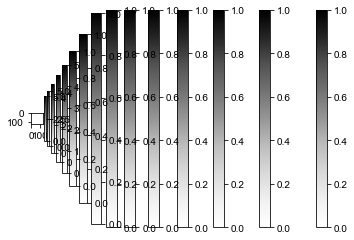

In [1615]:
## plotting the estimation of edge weights for ~10 sims under 3 different asymmetric rates 
estweight = np.zeros((5,3))
weights = np.array([0.2,1,5])
for iw, w in enumerate(weights):
    n_rows, n_columns = 8, 16
    graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5)
    lrn = [(36,91)]
    ## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
    graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_startpt=5.5, barrier_endpt=5.5,barrier_w=1.0, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[w])
    for n in range(5):
        gen_test_1e_asym = simulate_genotypes(graph, target_n_snps=750, mu=1e-1, n_print=500, asymmetric=True, long_range_nodes=lrn, long_range_edges=[w])
        # sp_Graph_asym = Joint_SpatialGraph(gen_test_1e_asym, coord, grid, edge_def)
        # sp_Graph_asym.fit(lamb=3., optimize_q='n-dim')
        # obj_asym = Joint_Objective(sp_Graph_asym); obj_asym.inv(); obj_asym.grad(reg=False)
        edges_lr = deepcopy(edge_def)
        edges_lr = edges_lr.tolist()
        edges_lr.append(list(x+1 for x in (lrn[0])))
        sp_graph_asym = Joint_SpatialGraph(gen_test_1e_asym, coord, grid, np.array(edges_lr), long_range_edges=lrn)
        sp_graph_asym.fit(lamb=3.,optimize_q='n-dim')
        estweight[n,iw] = sp_graph_asym.w[sp_graph_asym.lre_idx]
    print(estweight[:,iw])

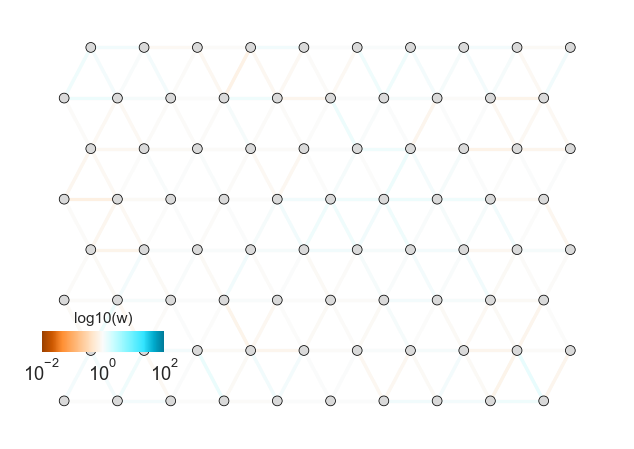

In [170]:
# sp_Graph_asym = Joint_SpatialGraph(gen_test_1e_asym, coord, grid, edge_def)
# sp_Graph_asym.fit(lamb=3., optimize_q='n-dim')
# obj_asym = Joint_Objective(sp_Graph_asym); obj_asym.inv(); obj_asym.grad(reg=False)

## recover_nnz_entries function in viz.py (same length as number of edges)
# W = sp_graph.inv_triu(np.random.binomial(n=1,p=0.5,size=len(sp_graph.edges)), perm=False)
# w = np.array([])
# idx = nx.adjacency_matrix(sp_graph).nonzero()
# idx = list(np.column_stack(idx))
# for i in range(len(idx)):
#     w = np.append(w, W[idx[i][0], idx[i][1]])

fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, #weights=w,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
# get_best_lre(sp_graph, gen_test_128_adm, coord_def, grid_def, edge_def, k=2, top=10)
v.draw_edge_colorbar()
# v.draw_c_colorbar()

In [102]:
## Write code to remove edges that have already been picked from reappearing in search
# def get_best_lre(sp_graph_lr, gen_test, coord, grid, edge_def, k=5, nfolds=None, lamb_cv=3., top=20):
#     sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2))
#     edges_lr = deepcopy(edge_def)
#     edges_lr = edges_lr.tolist()
#     ll_edges = np.empty((top,k))
#     top_edges = pd.DataFrame(index=range(top), columns=range(k))
#     for ik in range(k):
#         print("Starting search for edge {}...".format(ik+1))
#         lrn = comp_genetic_vs_fitted_distance(sp_graph_lr, n_lre=top, lamb=lamb_cv, plotFig=False, joint=True)
#         # lrn = list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)].values.reshape(top,2)))
#         edges_lr.append(list(x+1 for x in lrn[0]))
#         # print(len(edges_lr))
#         sp_graph_lr = Joint_SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=lrn[0:1])
#         sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2),verbose=False)
#         # print(len(sp_graph_lr.edges))
#         obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); 
#         ll_edges[0,ik] = -obj_lr.neg_log_lik()
#         for ie, e in enumerate(lrn[1:]):
#             ll_edges[ie+1,ik] = sub_edge_get_ll(sp_graph_lr, lrn[ie], lrn[ie+1], 3.)
#         print("{}, found at index {}.".format(lrn[np.argmax(ll_edges[:,ik])], np.argmax(ll_edges[:,ik])))
#         top_edges.iloc[:,ik] = lrn
#         sub_edge_get_ll(sp_graph_lr, lrn[len(lrn)-1], lrn[np.argmax(ll_edges[:,ik])], 3.)
#         edges_lr = [list(x+1 for x in lrn[np.argmax(ll_edges[:,ik])]) if item == list(x+1 for x in lrn[0]) else item for item in edges_lr] 
#         # print(len(edges_lr))
#         # print(lrn, ll_edges[:,ik])
#         # edges_lr.append(list(x+1 for x in lrn[np.argmax(ll_edges[:,ik])]))
#         # sp_graph = Joint_SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[lrn[np.argmax(ll_edges[:,ik])]])
#         sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2))
        
#     return ll_edges, top_edges

# def get_best_lre(sp_graph, gen_test, coord, grid, edge_def, k=2, nfolds=None, lamb_cv=3., top=20):
#     ## the graph has not been fit yet, so fit it again with the given lambda
#     if not hasattr(sp_graph, 'W'):
#         sp_graph.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph.s2))
    
#     # get a list of existing edges in the NO admixture edge object
#     edges_lr = deepcopy(edge_def)
#     edges_lr = edges_lr.tolist()
    
#     ll_edges = np.empty((top,k))
#     top_edges = pd.DataFrame(index=range(top), columns=range(k))
#     te = []

#     for ik in range(k):
#         print("Starting search for edge {}...".format(ik+1))
#         max_res_nodes = comp_genetic_vs_fitted_distance(sp_graph, n_lre=top, lamb=lamb_cv, plotFig=False, joint=True)
        
#         # code to exclude edges that have already been added in the previous steps
#         if ik>0:
#             max_res_nodes = [ele for ele in max_res_nodes if ele not in te]

#         # iterate across remaining edges
#         for ie, e in enumerate(max_res_nodes):
#             edges_t = deepcopy(edges_lr)
#             edges_t.append(list(x+1 for x in e))
#             sp_graph_lr = Joint_SpatialGraph(gen_test, coord, grid, np.array(edges_t), long_range_edges=max_res_nodes[ie:(ie+1)])
#             sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2),verbose=False)
#             obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); 
#             ll_edges[ie,ik] = -obj_lr.neg_log_lik()

#         print("{}, found at index {}.".format(max_res_nodes[np.argmax(ll_edges[:,ik])], np.argmax(ll_edges[:,ik])))
#         te.append(top_edges.iloc[np.argmax(ll_edges[:,ik]),ik])
#         top_edges.iloc[:,ik] = max_res_nodes

#         edges_lr.append(list(x+1 for x in max_res_nodes[np.argmax(ll_edges[:,ik])]))
#         sp_graph = Joint_SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[max_res_nodes[np.argmax(ll_edges[:,ik])]])
#         sp_graph.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph.s2))
        
#     return ll_edges, top_edges

In [17]:
## expected hitting times from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1456195/
# lamb_asym, v_asym = np.linalg.eig(nx.adjacency_matrix(sp_graph_asym).todense())
# H_asym = []
# for i in range(len(lamb_asym)):
#     H_asym.append(len(lamb_asym)*np.sum([(v_asym[k,0]**2-v_asym[k,i]*v_asym[k,0])/(1-lamb_asym[k]) for k in range(1,len(lamb_asym))]))

# plt.plot(H_asym)

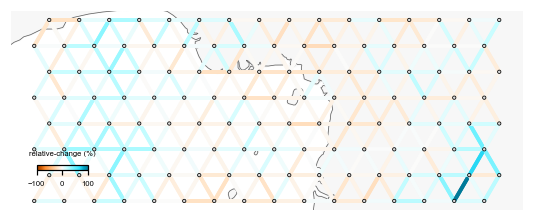

In [338]:
foldchange = (sp_graph_lr.w[~sp_graph_lr.lre_idx]-sp_Graph_def_jt.w)*100/sp_Graph_def_jt.w
fig = plt.figure(dpi=110) 
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_Graph_def_jt, projection=projection, edge_width=2.5, newweights=sp_graph_lr.w[~sp_graph_lr.lre_idx],
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, halfrange=100,
        obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=5,
        cbar_font_size=5, cbar_width='10%',cbar_height='2.5%')
v.draw_map()
v.draw_edges(use_weights=True, use_foldchange=True)
v.draw_obs_nodes()
# v.draw_edge_colorbar()
v.draw_edge_change_colorbar()

## Demes with small sample sizes

Scenarios:
1. NO long range edges but with few demes with small samples (<10% of larger demes)
2. ONE long range edge but between demes with large samples 

In [597]:
# n_rows, n_columns = 8, 10
# smallnodes = [12, 62,  9, 37, 25, 48, 53, 76]
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[4 if i in smallnodes else 40 for i in range(80)]) 
# gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1000)

# sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
# sp_Graph.fit(lamb=3., optimize_q='n-dim')
# obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

# print(get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1, top=20))

# lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1)

nreps = 30
fit_dist = np.zeros((sp_Graph.n_observed_nodes*(sp_Graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
rng = np.random.default_rng(2022); ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]
emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]

for n in range(1,nreps+1):
    bootgenotypes = deepcopy(gen_test_1e)
    ## if we bootstrap over SNPs, then we can do the below
    ## bootgenotypes[:,rng.choice(range(gen_test_1e.shape[1]),gen_test_1e.shape[1])]
    ## bootstrapping over inds (since this is the source of uncertainty)
    ctr = 0
    for deme in range(sp_Graph.n_observed_nodes):
        bootgenotypes[ctr:(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme]),:] = gen_test_1e[rng.choice(range(ctr,(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme])),sp_Graph.n_samples_per_obs_node_permuted[deme],replace=True),:]
        ctr += sp_Graph.n_samples_per_obs_node_permuted[deme]
    ## remove SNPs that are invariant after bootstrapping
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
    sp_graph_boot = Joint_SpatialGraph(bootgenotypes, coord, grid, edge)
    sp_graph_boot.fit(lamb=3., optimize_q='n-dim', verbose=False)
    obj_boot = Joint_Objective(sp_graph_boot)
    fit_cov, _, emp_cov = comp_mats(obj_boot)
    fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]
    emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]

In [602]:
## plotting the result, by first drawing the regression line using the whole data set
## linear regression result
X = sm.add_constant(fit_dist[:,0])
mod = sm.OLS(emp_dist[:,0], X)
res = mod.fit()
muhat, betahat = res.params
# residxy = np.zeros((fit_dist.shape[0],2))
# for i in range(fit_dist.shape[0]):
#     residxy[i,0] = fit_dist[i,0] - (emp_dist[i,0]-muhat)/betahat
#     residxy[i,1] = emp_dist[i,0] - (betahat*fit_dist[i,0]+muhat)
## lowess result
# res = sm.nonparametric.lowess(emp_dist[:,0],fit_dist[:,0],frac=0.1,xvals=np.linspace(np.min(fit_dist), np.max(fit_dist), 20))
## computing the standard errors from before
se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
for i in range(fit_dist.shape[0]):
    se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
    se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
se_resid = np.zeros(fit_dist.shape[0])
for i in range(fit_dist.shape[0]):
    se_resid[i] = np.std(((betahat*fit_dist[i,0]+muhat)-emp_dist[i,:])-res.resid[i])/np.sqrt(nreps)
## finding the largest outliers, taking into account the SE might overlap with best-fit line
max_idx = np.argpartition(res.resid, 100)[:100]
max_idx = max_idx[np.argsort(res.resid[max_idx])]
new_max_idx = []
for i in max_idx:
    if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
        new_max_idx.append(i)

# fig = plt.figure(dpi=80)
# ax = fig.add_subplot()
# ax.scatter(fit_dist[:,0], emp_dist[:,0], marker="o", alpha=0.8, zorder=0, color="grey", s=10)
# ax.errorbar(fit_dist[:,0],emp_dist[:,0],xerr=se_fit,yerr=se_emp, ecolor='grey', fmt='none',elinewidth=3,alpha=0.3)
# ax.scatter(fit_dist[new_max_idx,0], emp_dist[new_max_idx,0], marker="x", alpha=0.8, zorder=0, color="k", s=10)
# ax.errorbar(fit_dist[new_max_idx,0],emp_dist[new_max_idx,0],xerr=se_fit[new_max_idx],yerr=se_emp[new_max_idx], ecolor='k', fmt='none',elinewidth=4,alpha=0.5)
# x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
# ax.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=2)
# # ax.plot(x_, res, color="orange", linestyle='--', linewidth=2)
# ax.text(0.8, 0.05, "R²={:.3f}".format(res.rsquared), transform=ax.transAxes);
# ax.set_ylabel("genetic distance")
# ax.set_xlabel("fitted distance")

# plt.hist(res.resid,20); plt.title('residual in 2-dims')
# plt.hist(residxy[:,0],20,color='k',alpha=0.4); plt.title('residual in X-dim')
# plt.hist(residxy[:,1],20,color='k',alpha=0.4); plt.title('residual in Y-dim')
# sm.qqplot(residxy[:,1],line='q'); plt.title('residuals in 2-dim'); plt.show()
# plt.plot(np.sort(residxy[:,0]**2+residxy[:,1]**2),np.sort(res.resid),'ko')
# plt.plot(np.sort([residxy[i,0]**2+residxy[i,1]**2 if res.resid[i]>0 else -(residxy[i,0]**2+residxy[i,1]**2) for i in range(fit_dist.shape[0])]),np.sort(res.resid),'ko'); plt.axline((0,0),slope=1,color='grey')
# plt.plot(np.sort(residxy[:,0]),np.sort(residxy[:,1]),'o'); plt.axline((0,0),slope=1,color='grey'); plt.xlabel('X-dim'); plt.ylabel('Y-dim')

In [609]:
# np.savetxt('/Users/vivaswatshastry/Desktop/feemsashr.txt',np.vstack((res.resid,se_resid)).T)
# os.system('Rscript /Users/vivaswatshastry/Desktop/run_ashr.R')
# resash = np.loadtxt('/Users/vivaswatshastry/Desktop/feemsresash.txt',)
# sm.qqplot(resash[:,0],line='q'); plt.title('shrunk residuals (ashr)'); plt.show()
# max_idx_ash = np.argpartition(resash[:,0], 600)[:600]
# max_idx_ash = max_idx_ash[np.argsort(resash[max_idx_ash,0])]
# max_res_node_ash = []
# for k in max_idx_ash:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = np.int(k - 0.5*x*(x-1))
#     max_res_node_ash.append(tuple(sorted((x,y))))
# print(max_res_node_ash.index(lrn[0]))
# max_res_node_ash[:10]
get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,nreps=30,ntop=10,nchoose=600,option='ashr')
# max_idx_hard = np.argpartition(res.resid, 1000)[:1000]
# max_idx_hard = max_idx_hard[np.argsort(res.resid[max_idx_hard])]
# new_max_res_node = []
# for k in new_max_idx:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = np.int(k - 0.5*x*(x-1))
#     new_max_res_node.append(tuple(sorted((x,y))))
# print(new_max_res_node.index(lrn[0]))

[]

In [500]:
# new_max_res_node = []
# for k in new_max_idx:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = np.int(k - 0.5*x*(x-1))
#     new_max_res_node.append(tuple(sorted((x,y))))
# topedge = np.zeros((100,3))
# for ie, ee in enumerate(new_max_res_node):
#     if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
#         topedge[ie,0] += 1
#     elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
#         topedge[ie,1] += 1
#     else:
#         topedge[ie,2] += 1
# topedge.sum(axis=0)
# lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1)
# bootgenotypes.shape[0]

AttributeError: 'numpy.ndarray' object has no attribute 'resid'

In [330]:
## for the case with NO admixture BUT correction for standard errors
# llinc = np.zeros(30,); topedge = np.zeros((30,3),dtype='int'); 
# n_rows, n_columns = 8, 10
for n in range(4):
    # smallnodes = np.random.choice(range(80),8,replace=False)
    # smallnodes = [12, 62, 9, 37, 25, 48, 53, 76]

    # graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[4 if i in smallnodes else 40 for i in range(80)]) 

    # gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1200)
    # np.savetxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/gen80small{}.txt'.format(n),gen_test_1e,fmt='%f')
    gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/gen80small{}.txt'.format(n))

    sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
    sp_Graph.fit(lamb=3., optimize_q='n-dim', verbose=False)
    obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

    ## searching for best outlier node out of 20
    lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
    llinc[n] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
    ee = te.iloc[np.argmax(lle),0]
    if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
        topedge[n,0] += 1
    elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
        topedge[n,1] += 1
    else:
        topedge[n,2] += 1
    
    ## running the bootstrapping mechanism
    nreps = 20
    fit_dist = np.zeros((sp_Graph.n_observed_nodes*(sp_Graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
    rng = np.random.default_rng(2022); ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
    fit_cov, _, emp_cov = comp_mats(obj)
    fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]
    emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]

    for n in range(1,nreps+1):
        bootgenotypes = deepcopy(gen_test_1e)
        ## if we bootstrap over SNPs, then we can do the below
        ## bootgenotypes[:,rng.choice(range(gen_test_1e.shape[1]),gen_test_1e.shape[1])]
        ## bootstrapping over inds (since this is the source of uncertainty)
        ctr = 0
        for deme in range(sp_Graph.n_observed_nodes):
            bootgenotypes[ctr:(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme]),:] = gen_test_1e[rng.choice(range(ctr,(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme])),sp_Graph.n_samples_per_obs_node_permuted[deme],replace=True),:]
            ctr += sp_Graph.n_samples_per_obs_node_permuted[deme]
        ## remove SNPs that are invariant after bootstrapping
        bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
        bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
        sp_graph_boot = Joint_SpatialGraph(bootgenotypes, coord, grid, edge)
        sp_graph_boot.fit(lamb=3., optimize_q='n-dim',verbose=False)
        obj_boot = Joint_Objective(sp_graph_boot)
        fit_cov, _, emp_cov = comp_mats(obj_boot)
        fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]
        emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]

    X = sm.add_constant(fit_dist[:,0])
    mod = sm.OLS(emp_dist[:,0], X)
    res = mod.fit()
    muhat, betahat = res.params
    # computing the standard errors from before
    se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
    for i in range(fit_dist.shape[0]):
        se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
        se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
    # finding the largest outliers, taking into account the SE might overlap with best-fit line
    max_idx = np.argpartition(res.resid, 100)[:100]
    max_idx = max_idx[np.argsort(res.resid[max_idx])]
    new_max_idx = []
    for i in max_idx:
        if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
            new_max_idx.append(i)

    new_max_res_node = []
    for k in new_max_idx:
        x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
        y = np.int(k - 0.5*x*(x-1))
        new_max_res_node.append(tuple(sorted((x,y))))

    ll_edges = np.zeros((20,)); 
    for ie, e in enumerate(new_max_res_node[:20]):
        edges_t = deepcopy(edge.tolist())
        edges_t.append(list(x+1 for x in e))
        sp_graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_t), long_range_edges=new_max_res_node[ie:(ie+1)])
        sp_graph_lr.fit(lamb=3., optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2),verbose=False)
        obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); 
        ll_edges[ie] = -obj_lr.neg_log_lik()

    print(new_max_res_node[np.argmax(ll_edges)])

    if ee not in new_max_res_node:
        print("sim {}: top edge NOT found after correction. {}/20 left...\n".format(n, np.sum([te.iloc[i,0] in new_max_res_node for i in range(20)])))
    else:
        print("sim {}: {}/20 left...\n".format(n, np.sum([te.iloc[i,0] in new_max_res_node for i in range(20)])))

constant-w/variance fit, converged in 97 iterations, train_loss=-12150.6965079
lambda=3.0000000, alpha=0.7951398, converged in 12 iterations, train_loss=-13052.9709750
Starting search for edge 1...
(12, 37), found at index 0.
constant-w/variance fit, converged in 101 iterations, train_loss=-12294.3420486
lambda=3.0000000, alpha=0.8085983, converged in 9 iterations, train_loss=-14193.3519312
(71, 78)
sim 20: top edge NOT found after correction. 0/20 left...

constant-w/variance fit, converged in 109 iterations, train_loss=-12597.5124677
lambda=3.0000000, alpha=0.7561121, converged in 13 iterations, train_loss=-13365.8670281
Starting search for edge 1...
(37, 70), found at index 12.
constant-w/variance fit, converged in 101 iterations, train_loss=-12658.8789305
lambda=3.0000000, alpha=0.7802661, converged in 11 iterations, train_loss=-14334.4936021
(46, 70)
sim 20: top edge NOT found after correction. 0/20 left...

constant-w/variance fit, converged in 108 iterations, train_loss=-13741.6

In [333]:
new_max_res_node

[(2, 19), (19, 21), (2, 28), (63, 68), (19, 23), (21, 47)]

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 114 iterations, train_loss=26694.6687910
lambda=3.0000000, alpha=0.7432497, converged in 9 iterations, train_loss=24770.7137127
constant-w/variance fit, converged in 114 iterations, train_loss=26694.6687910
lambda=3.0000000, alpha=0.7432497, converged in 9 iterations, train_loss=24726.0988225
Starting search for edge 1...
(10, 19), found at index 2.
constant-w/variance fit, converged in 130 iterations, train_loss=26671.6679895
lambda=3.0000000, alpha=0.7897206, converged in 9 iterations, train_loss=24737.2838198
Simulating ~SNP 1000
constant-w/variance fit, converged in 118 iterations, train_loss=24375.5747222
lambda=3.0000000, alpha=0.7594077, converged in 11 iterations, train_loss=22549.6017338
constant-w/variance fit, converged in 118 iterations, train_loss=24375.5747222
lambda=3.0000000, alpha=0.7594077, converged in 12 iterations, train_loss=22512.3157933
Starting search for edge 1...
(20, 47), found at i

/Users/vivaswat/feems/feems/joint_ver.py:75: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswat/feems/feems/joint_ver.py:79: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswat/feems/feems/joint_ver.py:93: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(31, 37), found at index 5.
constant-w/variance fit, converged in 109 iterations, train_loss=24465.4396872
lambda=3.0000000, alpha=0.8535564, converged in 9 iterations, train_loss=22482.3657553
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 121 iterations, train_loss=24288.9292255
lambda=3.0000000, alpha=0.8004451, converged in 9 iterations, train_loss=22228.1237432
constant-w/variance fit, converged in 121 iterations, train_loss=24288.9292255
lambda=3.0000000, alpha=0.8004451, converged in 9 iterations, train_loss=22178.8651371
Starting search for edge 1...
(7, 9), found at index 8.
constant-w/variance fit, converged in 116 iterations, train_loss=24259.0332885
lambda=3.0000000, alpha=0.8126157, converged in 9 iterations, train_loss=22208.1687858
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 119 iterations, train_loss=26552.6153684
lambda=3.0000000, alpha=0.8054896, converged in 9 iterations, train_loss=24239.8998599
constant

/Users/vivaswat/feems/feems/joint_ver.py:75: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswat/feems/feems/joint_ver.py:79: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswat/feems/feems/joint_ver.py:93: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(7, 70), found at index 12.
constant-w/variance fit, converged in 112 iterations, train_loss=24813.7208425
lambda=3.0000000, alpha=0.8521788, converged in 9 iterations, train_loss=22873.3675732
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 120 iterations, train_loss=26819.8244709
lambda=3.0000000, alpha=0.7784440, converged in 9 iterations, train_loss=24907.1432253
constant-w/variance fit, converged in 120 iterations, train_loss=26819.8244709
lambda=3.0000000, alpha=0.7784440, converged in 9 iterations, train_loss=24858.0611572
Starting search for edge 1...
(33, 37), found at index 13.
constant-w/variance fit, converged in 117 iterations, train_loss=26746.2388384
lambda=3.0000000, alpha=0.7944864, converged in 10 iterations, train_loss=24878.8607123
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 123 iterations, train_loss=25291.8320730
lambda=3.0000000, alpha=0.7988672, converged in 11 iterations, train_loss=23396.8404836
con

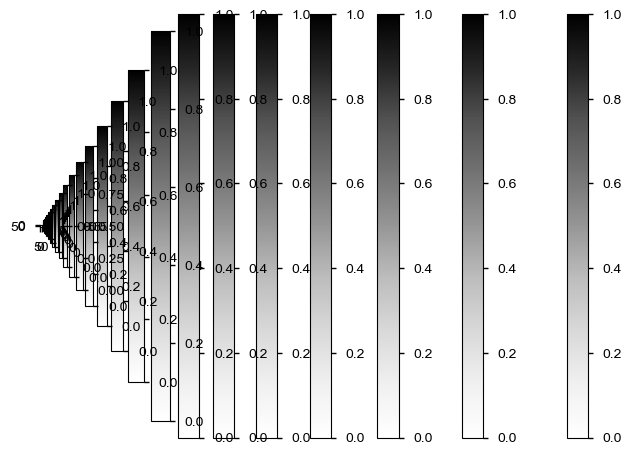

In [311]:
## for the case with NO admixture
cnt = 0; llinc = np.zeros(20,); topedge = np.zeros((20,3),dtype='int')
### llinc[:25] = deepcopy(llinc_null); topedge[:25,:] = deepcopy(topedge_null)
n_rows, n_columns = 8, 10
for n in range(20):
    # smallnodes = np.random.choice(range(80),8,replace=False)
    smallnodes = [12, 62, 9, 37, 25, 48, 53, 76]
    graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[2 if i in smallnodes else 20 for i in range(80)]) 
    # lrn = [(23, 56)]

    gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1000)
    # gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=2000, n_print=250, long_range_nodes=lrn, admixture_props=[0.25], time_of_adm=[0.00001])

    sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
    sp_Graph.fit(lamb=3., optimize_q='n-dim')
    obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

    lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
    llinc[n] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
    ee = te.iloc[np.argmax(lle),0]
    if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
        topedge[n,0] += 1
    elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
        topedge[n,1] += 1
    else:
        topedge[n,2] += 1  

In [406]:
gen_test_1e.shape

(1456, 1124)

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 133 iterations, train_loss=-35390.0514958
lambda=3.0000000, alpha=0.5743409, converged in 7 iterations, train_loss=-36602.9242113
constant-w/variance fit, converged in 133 iterations, train_loss=-35390.0514958
lambda=3.0000000, alpha=0.5743409, converged in 9 iterations, train_loss=-36108.4227041
Starting search for edge 1...
(23, 56), found at index 1.
constant-w/variance fit, converged in 124 iterations, train_loss=-35432.6499801
lambda=3.0000000, alpha=0.5884000, converged in 7 iterations, train_loss=-36745.6293496
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 131 iterations, train_loss=-35929.1890069
lambda=3.0000000, alpha=0.5891250, converged in 7 iterations, train_loss=-36998.1243836
constant-w/variance fit, converged in 131 iterations, train_loss=-35929.1890069
lambda=3.0000000, alpha=0.5891250, converged in 10 iterations, train_loss=-36566.2673286
Starting search for edg

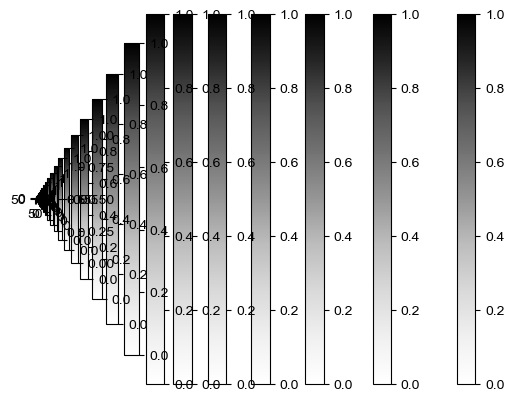

In [143]:
## for the case with admix prop c = [0.25, 0.5, 0.75]
llinc = np.zeros((2,3)); topedge = pd.DataFrame(index=range(2),columns=['0.2','0.5','0.8'])
# n_rows, n_columns = 8, 10
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=30) 
# lrn = [(23, 56)]
for ic, simc in enumerate([0.2,0.5,0.8]):
    for n in range(2):
        gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, long_range_nodes=lrn, admixture_props=[simc], time_of_adm=[0.0000001])

        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
        sp_Graph.fit(lamb=3., optimize_q='n-dim')
        obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

        lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
        llinc[n,ic] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
        topedge.iloc[n,ic] = te.loc[np.argmax(lle[:,0])][0]

In [617]:
## for the case with admix prop c = [0.25, 0.5, 0.75] but with bootstrapping
# llinc = np.zeros((15,3)); topedge = pd.DataFrame(index=range(15),columns=['0.125','0.25','0.375'])
# n_rows, n_columns = 8, 10
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=20) 
# lrn = [(23, 56)]
# lrnidx = np.zeros((15,3))
lrnidx_ashr = np.zeros((15,3))
for ic, simc in enumerate([0.125,0.25,0.375]):
    cntrec = 0; cnttot = 0
    print('for c={}...'.format(simc))
    for n in range(15):
        ## gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, long_range_nodes=lrn, admixture_props=[simc], time_of_adm=[0.0000001])
        ##np.savetxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c{}sim{}.txt'.format(simc,n),gen_test_1e)

        gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c{}sim{}.txt'.format(simc,n))

        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
        sp_Graph.fit(lamb=3., optimize_q='n-dim', verbose=False)
        obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

        # res_edges = comp_genetic_vs_fitted_distance(sp_Graph, n_lre=1000, lamb=3., plotFig=False, joint=True)
        # cnttot += lrn[0] in res_edges
        # lrnidx[n,ic] = res_edges.index(lrn[0])
        
        # res_edges = get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,ntop=600,nchoose=600)
        res_edges = get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,nreps=30,ntop=600,nchoose=1500,option='ashr')
        try:
            lrnidx_ashr[n,ic] = res_edges.index(lrn[0])
        except:
            lrnidx_ashr[n,ic] = 1000
        # cntrec += lrn[0] in res_edges
        # print('{}/{} out of 15'.format(cntrec,cnttot))
    
        # lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
        # llinc[n,ic] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
        # topedge.iloc[n,ic] = te.loc[np.argmax(lle[:,0])][0]
        # if (23,56) in new_max_res_node:
        #     print('sim {}: lrn not lost under bootstrapping!'.format(n))
        # else:
        #     print('sad :(')

for c=0.125...
for c=0.25...
for c=0.375...


In [618]:
# np.where(lrn[0] == res_edges)
# gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c0.125sim4.txt')

# sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
# sp_Graph.fit(lamb=3., optimize_q='n-dim', verbose=False)
# obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)
# lrnidx_ash

[]

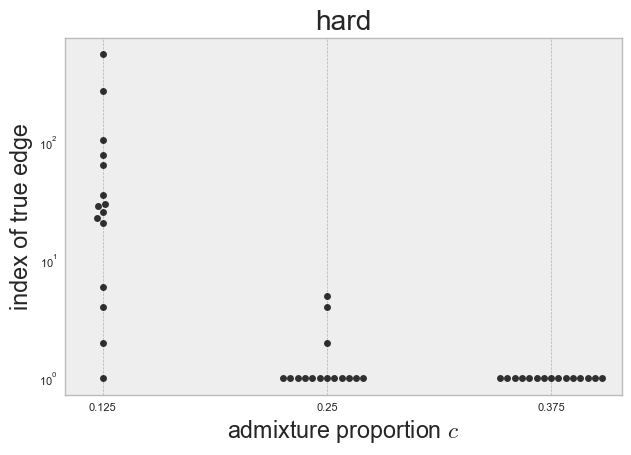

In [630]:
## include a counter for when both nodes are correctly identified and for when one node is correctly identified
# np.savetxt("/Volumes/GoogleDrive-115041122743441094352/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/llinc1edge8x10.txt",llinc)
# llinc0 = np.loadtxt("/Volumes/GoogleDrive-115041122743441094352/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/llinc0edge8x10.txt",skiprows=3)
# topedge.insert(0,'0',[(23,43)]*15)
# sns.swarmplot(data=pd.DataFrame(np.vstack((np.hstack((np.random.choice(llinc0,15).reshape(-1,1),llinc)).flatten(),[0,0.25,0.5,0.75]*15,np.ravel(topedge.apply(lambda x: x==(23,56))))).T,columns=['llinc','edge','true edge']),x='edge',y='llinc',hue='true edge',palette=['grey','k'],alpha=0.8,s=6); plt.legend(title='true edge?'); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('improvement in log-lik over next best edge'); plt.grid(); plt.axhline(15,color='grey',ls='--'); 
# sns.swarmplot(data=pd.DataFrame(np.vstack((lrnidx.flatten()+1,[0.125,0.25,0.375]*15)).T,columns=['lrnidx','c',]),x='c',y='lrnidx',alpha=0.8,s=5,color='k'); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('index of true edge'); plt.title('hard'); plt.grid(); plt.semilogy()
# lrnidx[:,1], lrnidx_boot[:,1], lrnidx_ashr[:,1]
# plt.plot(lrnidx_boot.flatten()+1,lrnidx.flatten()+1,'ko'); plt.axline((0,0),slope=1,color='grey'); plt.loglog()
# get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj)

In [230]:
# topedge.sum(axis=0)
# edges_lr = deepcopy(edge)
# edges_lr = edges_lr.tolist()
# edges_lr.append([24,57]); edges_lr.append([1,57]); edges_lr.append([73,78])
# sp_Graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_lr), long_range_edges=[(23,56),(0,56),(72,77)])
# sp_Graph_lr.fit(lamb=3.,optimize_q='n-dim')
# [lle[:,ix].max()-lle[x,ix] for ix, x in enumerate(lle[:,:].T.argsort()[:,-2])]
# lle[:,:].T.argsort()[:,-1]
# (lle-np.max(lle,axis=0).T).argsort(axis=0)[-2,:]
# [sorted(i)[-2] for i in zip(*lle)] 
# np.max(lle,axis=0) - np.sort(lle, axis=0)[-2,:] 
# [te.iloc[np.argmax(lle[:,i]),i]==(23,56) for i in range(3)]
# sns.stripplot(data=pd.DataFrame(np.vstack((llinc.flatten(),[1,2,3]*10,topedge)).T,columns=['llinc','edge','true edge']),x='edge',y='llinc',hue='true edge',palette=['grey','k'],alpha=0.8); plt.legend(title='true edge?'); plt.xlabel('# of edges'); plt.ylabel('improvement in log-lik over next best edge'); plt.grid();
# plt.bar(range(4),[5,2,3,0],color='grey',alpha=0.8); plt.xticks(range(4),labels=['0/3','1/3','2/3','3/3']); plt.xlabel('# of edges b/w small demes (in each sim)'); plt.ylabel('total number (across sims)')
# np.random.choice(range(80),8,replace=False)
## just count the number of possible edges bruh...
# s2stot = 0; s2ltot = 0; l2ltot = 0
# for ii in range(80):
#     for jj in range(ii+1,80):
#         if jj in list(sp_Graph.neighbors(ii)):
#             # if neighboring nodes, do not count as potential long range edges
#             continue
#         if ((ii in smallnodes) & (jj in smallnodes)):
#             s2stot += 1
#         elif (((ii in smallnodes) & (jj not in smallnodes)) | ((ii not in smallnodes) & (jj in smallnodes))):
#             s2ltot += 1
#         else:
#             l2ltot += 1

In [232]:
# s2stot, s2ltot, l2ltot, len(sp_Graph.edges)
## binomial proportion test 
# ZZ = (10/25-s2ltot/2955)/np.sqrt((10/25*15/25)/25 + (s2ltot/2955*(2955-s2ltot)/2955)/2955)

2955

Coding up this formula for different values of $c \in [0,1]$ and $\tau =\{5,25,50\}$ with $T'_{sd} = 500$ & $T'_{ss} = 20 (\ll T'_{sd})$ 

$T_{sd} = (1-c)T'_{sd} + c(2\tau + T'_{ss})$

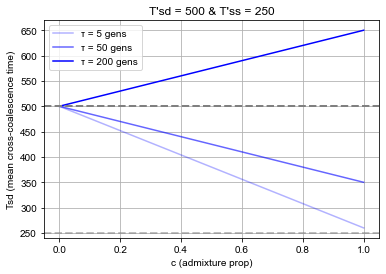

In [19]:
Tpsd = 500; Tpss = 250; c = np.linspace(0,1,20); tau = [5,50,200]
Tsd = (1-c)*Tpsd + c*(2*tau[0]+Tpss)
plt.plot(c, Tsd, color='blue', alpha=0.3, label='τ = 5 gens'); plt.ylabel('Tsd (mean cross-coalescence time)')
Tsd = (1-c)*Tpsd + c*(2*tau[1]+Tpss)
plt.plot(c, Tsd, color='blue', alpha=0.6, label='τ = 50 gens'); plt.title("T'sd = 500 & T'ss = 250"); plt.xlabel('c (admixture prop)'); 
Tsd = (1-c)*Tpsd + c*(2*tau[2]+Tpss)
plt.plot(c, Tsd, color='blue', alpha=1, label='τ = 200 gens'); plt.legend(); plt.grid()
plt.axhline(Tpsd, color='grey', ls='--', linewidth=2); plt.axhline(Tpss, color='grey', ls='--', alpha=0.5, linewidth=2); 
##########################################
# Tpsd = 500; Tpss = 20; tau = []
# Tsd = (1-c)*Tpsd + c*(2*tau[0]+Tpss)
# plt.plot(c, Tsd, color='deepskyblue', alpha=0.2, label='τ = 5 gens'); plt.ylabel('Tsd (mean cross-coalescence time)')
# Tsd = (1-c)*Tpsd + c*(2*tau[1]+Tpss)
# plt.plot(c, Tsd, color='deepskyblue', alpha=0.6, label='τ = 25 gens'); plt.title("T'sd = 500 & T'ss = 20"); plt.xlabel('c (admixture prop)'); 
# Tsd = (1-c)*Tpsd + c*(2*tau[2]+Tpss)
# plt.plot(c, Tsd, color='deepskyblue', alpha=1, label='τ = 50 gens'); plt.legend(); plt.grid()

## From msprime documentation: 

As described in the Definitions section, continuous migration between populations is modelled by a matrix of rates, so that $M[j, k]$ is the rate at which lineages move from population $j$ to population $k$ in the coalescent process, that is, backwards in time (see the Direction of time section for more details). Lineages that move from population $j$ to $k$ backwards in time actually correspond to individuals migrating from population $k$ to $j$ forwards in time.

### Computing the mean within-deme coalescent times

The relationship between off-diagonal elements of pseudo inverse of graph Laplacian and mean between-deme coalescent times are established: $T_{kl} \approx -dN_e L^\dagger_{kl} + N_e(2d+1)$. But how do the within-deme coalescent times relate to the diagonal elements (some kind of diversity measure)? 

## Also, what does $L^\dagger$ look like after admixture?

In [439]:
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=8, corridor_w=1., barrier_w=1., barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=1)
# graph, coord, grid, edge = setup_graph_long_range(n_rows=8, n_columns=8, corridor_w=1.0, barrier_startpt=5.5, barrier_endpt=5.5,barrier_w=1.0, barrier_prob=1.0, long_range_nodes=[(18,45)], long_range_edges=[2])

# gen_test1 = simulate_genotypes(graph_def, target_n_snps=1000, n_print=900, mu=1e-1, n_e=50,)# asymmetric=True, long_range_nodes=[(18,46)], long_range_edges=[5])

## new code for 6x6 grid
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=6, n_columns=6, corridor_w=1., barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=15)

lrn = [(8,27)]

# gen_test1 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=500, n_e=1, mu=1, long_range_nodes=lrn, admixture_props=[0], time_of_adm=[10])
# gen_test1e = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=500, n_e=1, mu=1, long_range_nodes=lrn, admixture_props=[0.5], time_of_adm=[0.0001])

# mytree = []
# for j in np.arange(1200): #np.random.randint(0,2500,500)
#     mytree.append(tskit.load(f"results/trees/mytesttreewadms{j}.tree"))

##largeNe sims are for 8x8 grid w lre: [18,45] & 2, 10 samples/node, n_e=50, 1000 SNPs: want to check if Tab≈-64Ldag+129 (for small n_e, slope is ~50)

Simulating ~SNP 0
Simulating ~SNP 500
Simulating ~SNP 1000


constant-w/variance fit, converged in 113 iterations, train_loss=-5064.2387775
lambda=3.0000000, alpha=0.5882484, converged in 8 iterations, train_loss=-5310.0012843
constant-w/variance fit, converged in 108 iterations, train_loss=-4906.0598810
lambda=3.0000000, alpha=0.5840798, converged in 6 iterations, train_loss=-5256.5793271
constant-w/variance fit, converged in 105 iterations, train_loss=-5036.2218813
lambda=3.0000000, alpha=0.6046794, converged in 7 iterations, train_loss=-5307.4002124
constant-w/variance fit, converged in 114 iterations, train_loss=-4999.8418772
lambda=3.0000000, alpha=0.6152175, converged in 6 iterations, train_loss=-5379.4858216


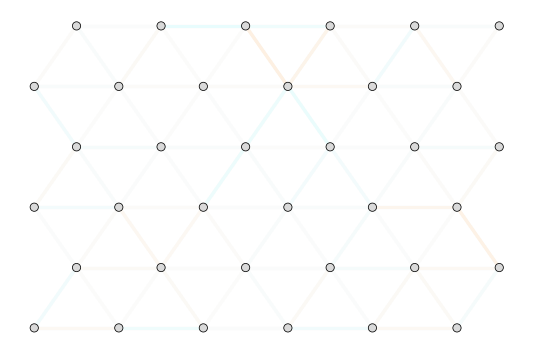

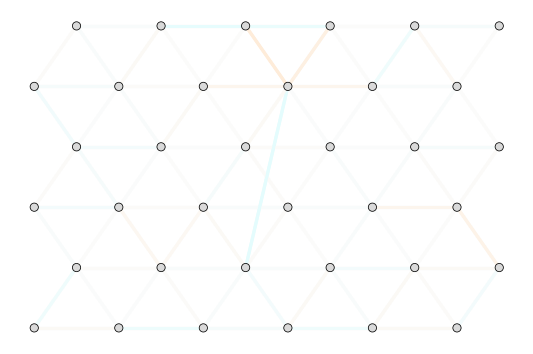

In [440]:
sp_Graph_def_jt = Joint_SpatialGraph(gen_test1,coord_def,grid_def,edge_def)
sp_Graph_def_jt.fit(lamb=3.,optimize_q='n-dim')
obj = Joint_Objective(sp_Graph_def_jt); obj.inv(); obj.grad(reg=False)

sp_Graph_def_jt = Joint_SpatialGraph(gen_test1e,coord_def,grid_def,edge_def)
sp_Graph_def_jt.fit(lamb=3.,optimize_q='n-dim')
obj_e = Joint_Objective(sp_Graph_def_jt); obj_e.inv(); obj_e.grad(reg=False)

fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_Graph_def_jt, projection=ccrs.Mercator(), edge_width=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)

edges_lr = deepcopy(edge_def)
edges_lr = edges_lr.tolist()
edges_lr.append(list(x+1 for x in (8,27)))
sp_Graph_asym = Joint_SpatialGraph(gen_test1, coord_def, grid_def, np.array(edges_lr), long_range_edges=[(8,27)])
sp_Graph_asym.fit(lamb=3., optimize_q='n-dim'); 
obj_asym = Joint_Objective(sp_Graph_asym); obj_asym.inv(); obj_asym.grad(reg=False)

sp_Graph_asym = Joint_SpatialGraph(gen_test1e, coord_def, grid_def, np.array(edges_lr), long_range_edges=[(8,27)])
sp_Graph_asym.fit(lamb=3., optimize_q='n-dim'); 
obj_asym_e = Joint_Objective(sp_Graph_asym); obj_asym_e.inv(); obj_asym_e.grad(reg=False)

fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_Graph_asym, projection=ccrs.Mercator(), edge_width=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)

In [836]:
def comp_fst_mat(genotypes, n_inds, n_demes):
    """Computes an Fst distance matrix from a sample
    genotype matrix and set of sub-population ids
    """
    n_snps = genotypes.shape[1]
    acs = np.empty((n_demes, n_snps, 2))
    
    # compute allele counts
    for i in range(n_demes):
        Gi = genotypes[np.arange(i*n_inds,(i+1)*n_inds), :]
        acs[i, :, 0] = np.sum(Gi, axis=0)
        acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
    # compute Fst matrix
    Fst = np.empty((n_demes, n_demes))
    for i in range(n_demes):
        for j in range(n_demes):
            Fst[i, j] = np.sum(allel.mean_pairwise_difference_between(acs[i, :, :].astype(np.int32), acs[j, :, :].astype(np.int32)))/n_snps

    for i in range(n_demes):
        Fst[i, i] = np.sum(allel.mean_pairwise_difference(acs[i, :, :].astype(np.int32)))/n_snps
    return(Fst)

# Fst = comp_fst_mat(gen_test1,20,12)
# plt.imshow(sp_Graph_asym.S,cmap='RdBu_r'); plt.colorbar()

In [346]:
# def avg_coal_time(tree):
#     coalescence_time = 0
#     sample_size = tree.get_sample_size()
#     for leaves in tree.samples():
#         num_branch = 0
#         u = leaves
#         visited = np.array([u])
#         while u != tskit.NULL:
#             u = tree.parent(u)
#             if u !=-1 :
#                 node_children = np.array(tree.children(u))
#                     #print("{}:{}".format(u, node_children))                                                                                               
#                 node_interest = np.setdiff1d(node_children, visited)
#                 if len(node_interest)!=0:
#                     for j in range(len(node_interest)):
#                         num_leaves = tree.get_num_leaves(node_interest[j])
#                         node_branch_len = tree.time(u) * num_leaves
#                         coalescence_time = coalescence_time + node_branch_len
#                         visited = np.append(visited, u)
#                         num_branch =+ num_leaves

#         #print("leaves{}:{},{}".format(leaves, num_branch, visited))                                                                                       
#     return(coalescence_time/(sample_size * (sample_size-1)))

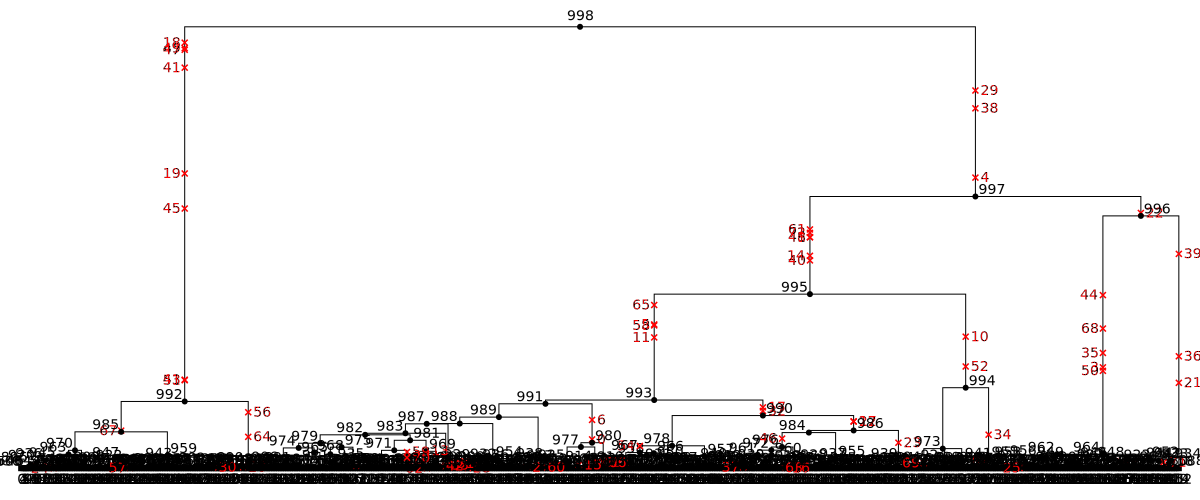

In [1767]:
## checking if the code below works correctly
# tt = mytree[1].first()
# [tt.tmrca(0,j) for j in range(8)]
from IPython.display import SVG
SVG(mytree[9].first().draw_svg(size=(1200,500)))
# mytree[1].first().num_samples()

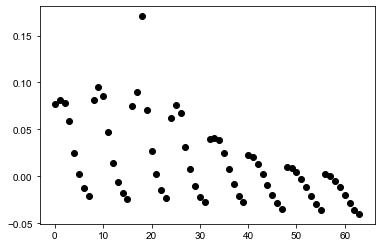

In [1820]:
# np.polyfit(np.ravel(coaltimematNe1[np.tril_indices_from(coaltimemat,-1)]),np.ravel(coaltimemat[np.tril_indices_from(coaltimemat,-1)]),deg=1)
# plt.scatter(coaltimematNe1[np.tril_indices_from(coaltimematNe1,-1)],coaltimemat[np.tril_indices_from(coaltimemat,-1)],color='k',alpha=0.8,); 
# plt.xlabel('average coalescent time with Ne = 1'); plt.ylabel('average coalescent times with Ne = 10'); plt.autoscale()
# plt.axline((0,81),slope=.34,color='grey',ls='--',label='({},{})'.format(1.0,161)); plt.legend(); 
plt.plot(obj.Linv[18,],'ko')

In [380]:
## code for calculating average coalescent time between & within demes for equal # of inds in demes
ndemes = 36; ninds = 2*15; nsnps = 600
coaltimemat = np.zeros((ndemes,ndemes))
for snp in range(nsnps):
    tt = mytree[snp].first()
    for i in range(ninds*ndemes):
        for j in range(i+1,ninds*ndemes):
            coaltimemat[int(i/ninds),int(j/ninds)] += tt.tmrca(i,j)

coaltimemat[np.diag_indices_from(coaltimemat)] /= np.sum(range(ninds))
coaltimemat[np.triu_indices_from(coaltimemat,1)] /= ninds*ninds

## code for calculating average coalescent time between & within demes for different # of inds in demes
# ss = np.array(list(nx.get_node_attributes(graph_def,"sample_size").values())); 
# ndemes = len(ss); nsnps = 2000
# coaltimemat = np.zeros((ndemes,ndemes))
# for snp in range(nsnps):
#     tt = mytree[snp].first()
#     for d1 in range(ndemes):
#         for d2 in range(d1,ndemes):
#             for i in range(ss[d1]):
#                 for j in range(ss[d2]):
#                     coaltimemat[d1,d2] += tt.tmrca(i+np.sum(ss[:d1]),j+np.sum(ss[:d2]))

# for d1 in range(ndemes):
#     for d2 in range(d1,ndemes):
#         if d1 != d2:
#             coaltimemat[d1,d2] /= ss[d1]*ss[d2]
#         else:
#             coaltimemat[d1,d1] /= np.sum(range(ss[d1]))

coaltimemat = coaltimemat + coaltimemat.T
coaltimemat[np.diag_indices_from(coaltimemat)] *= 0.5
coaltimemat /= nsnps #*0.5/Ne

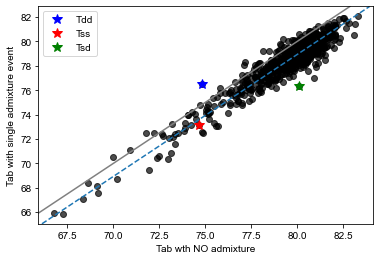

In [468]:
# plt.plot(np.ravel(coaltimemat[np.triu_indices(36)]),np.ravel(coaltimematxx[np.triu_indices(36)]),'ko',alpha=0.7); plt.axline((70,70),slope=1,color='grey'); plt.xlabel('Tab wth NO admixture'); plt.ylabel('Tab with single admixture event'); plt.plot(coaltimemat[27,27],coaltimematxx[27,27],'b*',markersize=10,label='Tdd'); plt.plot(coaltimemat[8,8],coaltimematxx[8,8],'r*',markersize=10,label='Tss'); plt.plot(coaltimemat[8,27],coaltimematxx[8,27],'g*',markersize=10,label='Tsd'); plt.legend(); plt.axline((71.07,70),slope=1,ls='--')
# plt.imshow(coaltimemat); plt.colorbar(); plt.show()
# plt.imshow(coaltimematxx); plt.colorbar(); plt.show()

# np.polyfit(np.ravel(coaltimematxx[np.triu_indices(36)]),np.ravel(coaltimemat[np.triu_indices(36)]),deg=1)
# np.polyfit(np.ravel(obj_asym_e.Linv[np.triu_indices(36)]),np.ravel(obj_asym.Linv[np.triu_indices(36)]),deg=1)
# obj_asym_e.Linv[8,8], obj_asym.Linv[8,8]
# np.mean(coaltimematxx[np.triu_indices(36)]) - np.mean(coaltimemat[np.triu_indices(36)])
# plt.plot(np.ravel(obj_asym_e.Linv[np.triu_indices(36)]),np.ravel(obj_asym.Linv[np.triu_indices(36)]),'ko')
# np.polyfit(np.ravel(obj_e.Linv[np.triu_indices(36)]),np.ravel(obj.Linv[np.triu_indices(36)]),deg=1)
# plt.plot(np.ravel(obj_e.Linv[np.triu_indices(36)]),np.ravel(obj.Linv[np.triu_indices(36)]),'b+')

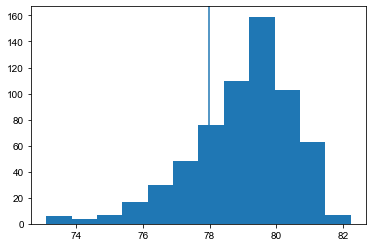

In [184]:
# np.polyfit(obj.Linv[np.tril_indices_from(obj.Linv,-1)], coaltimemat[np.tril_indices_from(coaltimemat,-1)], deg=1, full=True)
# plt.scatter(np.ravel(coaltimematxx),np.ravel(coaltimemat*2*10),alpha=0.7,color='k'); #plt.axline((150,150),slope=1,ls='--',color='grey')
# plt.ylabel('average coalescent time with Ne=10'); plt.xlabel('rescaled average coalescent time with Ne=1')
# plt.scatter(np.ravel(obj_asym.Linv),np.ravel(obj.Linv),color='k',alpha=0.25); plt.axline((0,0),slope=1,ls='--',color='grey')
# plt.scatter(obj_asym.Linv[6,18], obj.Linv[6,18], s=200.5,marker='*'); plt.show()
# plt.hist(np.ravel(np.triu(obj_asym.Linv)-np.triu(obj.Linv)),25); plt.axvline(obj_asym.Linv[6,18]-obj.Linv[6,18],ls='--')
# coaltimemat[8,8], coaltimemat[8,27], coaltimemat[27,27]
# plt.plot(np.diag(coaltimemat),'ko',alpha=0.8); plt.grid(); 

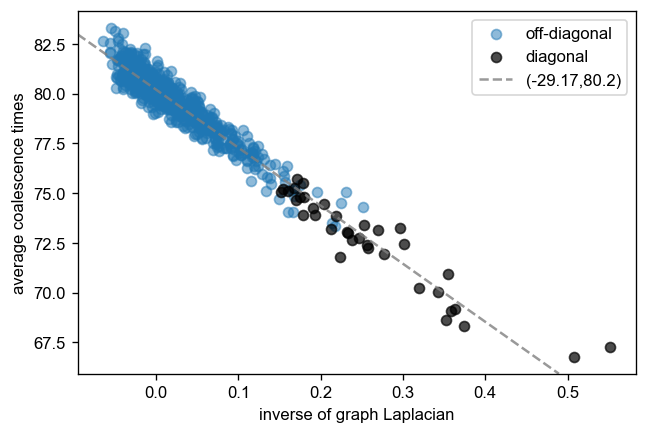

In [438]:
fig = plt.figure(dpi=120)
plt.scatter(obj.Linv[np.tril_indices_from(obj.Linv,-1)],coaltimemat[np.tril_indices_from(coaltimemat,-1)], alpha=0.5, label='off-diagonal'); 
# m1, b1 = np.polyfit(coaltimemat[np.tril_indices_from(coaltimemat,-1)], obj.Linv[np.tril_indices_from(obj.Linv,-1)], deg=1)
# plt.plot(np.linspace(np.min(coaltimemat),np.max(coaltimemat)), b1+m1*np.linspace(np.min(coaltimemat),np.max(coaltimemat)), ls='--', label='({:.2f},{:.1f})'.format(m1,b1), alpha=0.6)
plt.scatter(np.diag(obj.Linv), np.diag(coaltimemat), color='k', alpha=0.7, label='diagonal'); 
# plt.axvline(1/ndemes,color='red',ls='--'); plt.axvline(1/50,color='red',ls='--'); 
# m2, b2 = np.polyfit(np.diag(coaltimemat), np.diag(obj.Linv), deg=1)
# plt.axline((0,b2),slope=m2,color='grey',ls='--',alpha=0.6,label='({:.2f},{:.1f})'.format(m2,b2))
m3, b3 = np.polyfit(obj.Linv[np.tril_indices_from(obj.Linv)],coaltimemat[np.tril_indices_from(coaltimemat)], deg=1); 
plt.axline((0.0,80.2),slope=m3, ls='--', label='({:.2f},{:.1f})'.format(m3,b3), alpha=0.8, color='grey')
plt.ylabel('average coalescence times'); plt.xlabel('inverse of graph Laplacian'); plt.legend(); #plt.xlim((np.min(obj.Linv),np.max(obj.Linv)))

In [1287]:
## code to calculate Rab = 1/Cab = 1/Mab = (Tab - (Taa+Tbb)/2)/((Taa+Tbb)/8)
rab_coal, tauab, rab_ldag, rab_ldag2 = [], [], [], []
for a in range(ndemes):
    for b in range(a+1,ndemes):
        rab_coal.append((coaltimemat[a,b]-0.5*(coaltimemat[a,a]+coaltimemat[b,b]))/(0.125*(coaltimemat[a,a]+coaltimemat[b,b])))
        rab_ldag.append(-2*obj.Linv[a,b]+obj.Linv[a,a]+obj.Linv[b,b])
        rab_ldag2.append(-2*newLinv[a,b]+newLinv[a,a]+newLinv[b,b])
        tauab.append(coaltimemat[a,b]-0.5*(coaltimemat[a,a]+coaltimemat[b,b]))

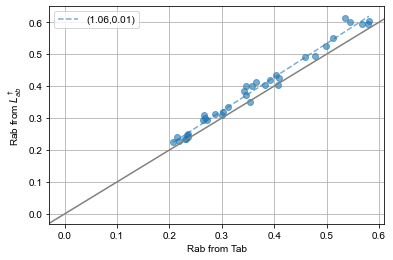

In [1288]:
m1, b1 = np.polyfit(rab_coal, rab_ldag, deg=1)
plt.plot(np.linspace(np.min(rab_coal),np.max(rab_coal)), b1+m1*np.linspace(np.min(rab_coal),np.max(rab_coal)), ls='--', label='({:.2f},{:.2f})'.format(m1,b1), alpha=0.6); plt.legend(); plt.ylabel(r'Rab from $L_{ab}^\dagger$'); plt.xlabel('Rab from Tab'); plt.grid()
plt.scatter(rab_coal,rab_ldag,alpha=0.6); plt.axline((0,0),slope=1,color='grey'); 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


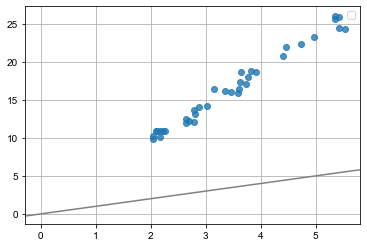

In [1290]:
# plt.scatter(np.ravel(coaltimemat[np.triu_indices_from(coaltimemat,1)]),ndemes/4*np.array(rab_coal),color='k'); plt.grid()
# meantmrca = 0
# for i in range(ndemes):
#     for j in range(i+1,ndemes):
#         meantmrca += 0.125*(coaltimemat[i,i]+coaltimemat[j,j])
# print(meantmrca*2/(ndemes*(ndemes-1)))
# m, b = np.polyfit(rab_coal,tauab,deg=1)
## for ndemes = d = 12:
# plt.scatter(rab_coal,np.array(tauab)/6,alpha=0.8,label=r'$\tau_{{ab}}$, slope = {:.1f}, int = 0'.format(ndemes/2)); plt.xlabel('$R_{ab}$'); 
# plt.scatter(rab_coal,-(np.ravel(obj.Linv[np.triu_indices_from(obj.Linv,1)])-0.16)/0.24,alpha=0.8,label='$L^\dagger_{{ab}}$, slope = {:.2f}, int = {:.2f}'.format(-0.24,0.16)); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.legend(); plt.grid()
## for ndemes = d = 9 & Ne = 1: 
plt.scatter(np.array(rab_ldag)*ndemes,tauab,alpha=0.8)
# plt.scatter(rab_coal,np.array(tauab)/450,alpha=0.8,label=r'$\tau_{{ab}}$, slope = {:.2f}, int = 0'.format(45)); plt.xlabel('$R_{ab}$'); 
# plt.scatter(rab_coal,-(np.ravel(obj.Linv[np.triu_indices_from(obj.Linv,1)])-0.111111)/0.5,alpha=0.8,label='$L^\dagger_{{ab}}$, slope = {:.2f}, int = {:.2f}'.format(-0.3,0.12)); 
plt.axline((0,0),slope=1,color='grey'); plt.legend(); plt.grid()
## for ndemes = d = 9 & Ne = 10: 
# plt.scatter(rab_coal,tauab,alpha=0.8,label=r'$\tau_{{ab}}$, slope = {:.1f}, int = 0'.format(3.)); plt.xlabel('$R_{ab}$'); 
# plt.scatter(rab_coal,-(np.ravel(obj.Linv[np.triu_indices_from(obj.Linv,1)])-0.1175)/0.24,alpha=0.8,label='$L^\dagger_{{ab}}$, slope = {:.2f}, int = {:.2f}'.format(-0.26,0.12)); plt.axline((0,0),slope=3,color='grey',ls='--'); plt.legend(); plt.grid()

In [1083]:
print(np.polyfit(obj.Linv[np.triu_indices_from(obj.Linv,1)],tauab,deg=1))
print(np.polyfit(rab_coal,obj.Linv[np.triu_indices_from(obj.Linv,1)],deg=1))
print(np.polyfit(np.ravel(obj.Linv),np.ravel(coaltimemat),deg=1))
print(np.polyfit(tauab,coaltimemat[np.triu_indices_from(coaltimemat,1)],deg=1))
# print(np.polyfit(obj.Linv[np.triu_indices_from(obj.Linv)],coaltimemat[np.triu_indices_from(coaltimemat)], deg=1)) -> same as for k=1
print("")
print(np.polyfit(obj.Linv[np.triu_indices_from(obj.Linv,1)],rab_ldag,deg=1))
print(np.polyfit(rab_ldag,tauab,deg=1))

[-99.68141166  10.29351013]
[-0.32573714  0.09337111]
[-85.50453368 245.30105057]
[  0.33079553 237.63292401]

[-2.43220209  0.24737059]
[40.31193283  0.18868992]


In [1146]:
## reading in trees from SLiM (https://github.com/petrelharp/isolation_by_coalescence)
# origts = tskit.load("/Users/vivaswat/feems/docs/notebooks/results/slimtrees/pop_10000.trees")
origtree = []
for t in origts.trees():
    origtree.append(t)